# Title: Final Project Data Exploration and Data Analysis
#### Author: Sanjay Jaras

#### Table of contents
* Import Libraries [](#Import-Libraries)
* Configurations [](#configurations)
* Read Yaml File [](#Read-Yaml-File)
* Unzip Dataset Files [](#Unzip-Dataset-Files)
* Add Dummy Columns [](#Add-Dummy-Columns)
* Dataframe For Match [](#Dataframe-For-Match)
* Dataframe For Batsman [](#Dataframe-For-Batsman)
* Dataframe For Innings [](#Dataframe-For-Innings)
* DataFrame Batsman Info Per Match [](#DataFrame-Batsman-Info-Per-Match)
* DataFrame Batsman Info Season [](#DataFrame-Batsman-Info-Season)
* Histogram Innings per Match [](#Histogram-Innings-per-Match)
* Remove Outlier Innings [](#Remove-Outlier-Innings)
* Remove Outlier No-Results [](#Remove-Outlier-No-Results)
* Scatter-Plot Scores Per Innings [](#Scatter-Plot-Scores-Per-Innings)
* Histogram Mumbai-Indians All Seasons [](#Histogram-Mumbai-Indians-All-Seasons)
* Histogram Other Teams All Seasons [](#Histogram-Other_Teams-All-Seasons)
* Comparison with PMF [](#Comparison-with-PMF)
* Comparison with CDF [](#Comparison-with-CDF)
* Normal Distribution CDF Comparison [](#Normal-Distribution-CDF-Comparison)
* Scatter-Plot Opener Contribution [](#Scatter-Plot-Opener-Contribution)
* Scatter-Plot First Six Overs Score [](#Scatter-Plot-First-Six-Overs-Score)
* Scatter-Plot Last Five Overs Score [](#Scatter-Plot-Last-Five-Overs-Score)
* Scatter-Plot Runs Conceded in First Six Overs [](#Scatter-Plot-Runs-Conceded-in-First-Six-Overs)
* Scatter-Plot Runs Conceded in Last Five Overs [](#Scatter-Plot-Runs-Conceded-in-Last-Five-Overs)
* Hypothesis Test [](#Hypothesis-Test)
* Logistic Regression [](#Logistic-Regression)
* Fitting model with all data [](#Fitting-model-with-all-data)
* Model Accuracy with all data [](#Model-Accuracy-with-all-data)
* Model Accuracy with split data [](#Model-Accuracy-with-split-data)
* Histogram Matches Per Season [](#Histogram-Matches-Per-Season)
* Histogram Matches Per Location [](#Histogram-Matches-Per-Location)
* Histogram For Toss Winners [](#Histogram-For-Toss-Winners)
* Histogram For Match Winners [](#Histogram-For-Match-Winners)
* Histogram For Man-of-the-Match [](#Histogram-For-Man-of-the-Match)
* Histogram No of centuries by players [](#Histogram-No-of-centuries-by-players)
* Histogram No of half-centuries by players [](#Histogram-No-of-half-centuries-by-players)
* Histogram for Strike Rates by Batsman [](#Histogram-for-Strike-Rates-by-Batsman)


## Import Libraries <a class="anchor" id="Import-Libraries"></a>

Import other modules

In [1]:
import csv
import sys
import time

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import yaml

%matplotlib inline
from IPython.display import set_matplotlib_formats
from scipy import stats as scistats

# iplclasses: module for classes that used in converting per match yaml files to consolidated data frame
# pmfcdf: module to calculate PMF and CDF
# categoricalcorr: module to find correlation with categorical variables
# hypothesistest: module to test null hypothesis
from iplhelpers import categoricalcorr as cc
from iplhelpers import hypothesistest as hptest
from iplhelpers import iplclasses, pmfcdf
from iplhelpers import yamlutils as yu
from iplhelpers import ziputils as zp

## Configurations <a class="anchor" id="configurations"></a>
Configurations for pandas and matplot library

In [2]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", None)

set_matplotlib_formats("png", "pdf")
plt.style.use(
    "seaborn-darkgrid"
)  # fivethirtyeight,ggplot,seaborn-darkgrid,seaborn-whitegrid
plt.rcParams["figure.figsize"] = [24, 12]

## Read Yaml File <a class="anchor" id="Read-Yaml-File"></a>
Test Yaml File Reading

In [3]:
# yamlIn = open("392190.yaml", "r") # tie
yamlIn = open("335982.yaml", "r")  # first match
yamlFile = yaml.load(yamlIn, Loader=yaml.FullLoader)
tempDf = yu.readYamlToDataFrame(1, yamlFile)
tempDf.head()
tempGroupByInnings = tempDf.groupby(by=["MatchId", "InningNo"])
tempTeamsTotalRuns = tempGroupByInnings["TotalRuns"].sum()

## Unzip Dataset Files <a class="anchor" id="Unzip-Dataset-Files"></a>
Unzip dataset file combine all files into one dataframe. Also create some dummy columns.

In [4]:
df = zp.extractZipAndProcess("ipl.zip")
df.to_csv("all-records.csv", index=False)
# df = pd.read_csv("all-records.csv")

Done processing in 109.99354781500006 seconds


In [5]:
print("Last 5 records", df.tail())
# df.to_csv('all-records.csv', index=False)
print("Shape", df.shape)
print("Columns", df.columns)

Last 5 records         MatchId        Date       City           Team1                Team2  \
179053      756  2019-05-12  Hyderabad  Mumbai Indians  Chennai Super Kings   
179054      756  2019-05-12  Hyderabad  Mumbai Indians  Chennai Super Kings   
179055      756  2019-05-12  Hyderabad  Mumbai Indians  Chennai Super Kings   
179056      756  2019-05-12  Hyderabad  Mumbai Indians  Chennai Super Kings   
179057      756  2019-05-12  Hyderabad  Mumbai Indians  Chennai Super Kings   

            TossWinner TossDecision ManOfTheMatch          Winner  WonByRuns  \
179053  Mumbai Indians          bat     JJ Bumrah  Mumbai Indians          1   
179054  Mumbai Indians          bat     JJ Bumrah  Mumbai Indians          1   
179055  Mumbai Indians          bat     JJ Bumrah  Mumbai Indians          1   
179056  Mumbai Indians          bat     JJ Bumrah  Mumbai Indians          1   
179057  Mumbai Indians          bat     JJ Bumrah  Mumbai Indians          1   

        ...          BattingT

## Add Dummy Columns <a class="anchor" id="Add-Dummy-Columns"></a>
Add dummy columns like Season. Also data correction for city renaming etc.

In [6]:
# added Column Season with Year of match
df["Season"] = pd.DatetimeIndex(df["Date"]).year
# replace Bangalore with Bengaluru
df.City.replace("Bangalore", "Bengaluru", inplace=True)
df.ManOfTheMatch.fillna("-", inplace=True)

In [7]:
df["Fours"] = df["RunsBat"] == 4
df["Sixes"] = df["RunsBat"] == 6
groupByInnings = df.groupby(by=["MatchId", "InningNo"])
teamsTotalRuns = groupByInnings["TotalRuns"].sum()
boundriesPerInnings = groupByInnings["Fours"].sum() + groupByInnings["Sixes"].sum()

In [8]:
ballsFirst6Overs = df[df["BallNo"] < 6]
ballsLast5vers = df[df["BallNo"] > 15]
grpByInningFirst6 = ballsFirst6Overs.groupby(by=["MatchId", "InningNo"])
grpByInningLast5 = ballsLast5vers.groupby(by=["MatchId", "InningNo"])

firstSixOversTotal = grpByInningFirst6["TotalRuns"].sum()
lastFiveOvers = grpByInningLast5["TotalRuns"].sum()

## Dataframe For Match <a class="anchor" id="Dataframe-For-Match"></a>
Create DataFrame for match Information.

In [9]:
matchinfo = df.groupby(by=["MatchId"])
dfMatchInfo = matchinfo.head(n=1)
dfMatchInfo.shape

(756, 25)

## Dataframe For Batsman <a class="anchor" id="Dataframe-For-Batsman"></a>
Create DataFrame for batsman Information.

In [10]:
df_batsman = pd.DataFrame.copy(df)
df_batsman = df.groupby(by=["MatchId", "InningNo", "Batsman"])
runsByBatsmanPermatch = df_batsman.agg({"RunsBat": "sum", "BallNo": "count"})

## Dataframe For Innings <a class="anchor" id="Dataframe-For-Innings"></a>
Create DataFrame for each innings Information. This dataframe is used for most of the analysis.</br>
Added following columns</br>
* opener1Runs
* opener2Runs
* OpenersTotalRuns
* teamTotal
* boundries
* firstSixTotal
* lastFiveTotal
* boundriesGiven
* firstSixTotalGiven
* lastFiveTotalGiven
* oppisitionTotalRuns
* Won
* Chasing
* WonToss


In [11]:
def getLocatedValue(dfToLocate, matchId, innings):
    result = 0
    try:
        result = dfToLocate.loc[matchId, innings]
    except KeyError:
        result = 0
    return result

In [12]:
inningsInfo = groupByInnings.head(n=1)
print(inningsInfo.shape)
d = {"runsOpener1": [], "runsOpener2": []}
runsForOpener = pd.DataFrame(data=d)
for index, row in inningsInfo.iterrows():
    try:
        opener1Runs = runsByBatsmanPermatch.loc[
            row["MatchId"], row["InningNo"], row["Opener1"]
        ]["RunsBat"]
        opener2Runs = runsByBatsmanPermatch.loc[
            row["MatchId"], row["InningNo"], row["Opener2"]
        ]["RunsBat"]

    except KeyError:
        opener1Runs = 0
        opener2Runs = 0

    teamTotal = getLocatedValue(teamsTotalRuns, row["MatchId"], row["InningNo"])
    boundries = getLocatedValue(boundriesPerInnings, row["MatchId"], row["InningNo"])
    firstSixTotal = getLocatedValue(firstSixOversTotal, row["MatchId"], row["InningNo"])
    lastFiveTotal = getLocatedValue(lastFiveOvers, row["MatchId"], row["InningNo"])

    if row["InningNo"] % 2 == 0:
        oppInnings = row["InningNo"] - 1
    else:
        oppInnings = row["InningNo"] + 1

    boundriesGiven = getLocatedValue(boundriesPerInnings, row["MatchId"], oppInnings)
    firstSixTotalGiven = getLocatedValue(firstSixOversTotal, row["MatchId"], oppInnings)
    lastFiveTotalGiven = getLocatedValue(lastFiveOvers, row["MatchId"], oppInnings)

    oppisitionTotalRuns = getLocatedValue(teamsTotalRuns, row["MatchId"], oppInnings)

    if row["BattingTeam"] == row["Team1"]:
        opposition = row["Team2"]
    else:
        opposition = row["Team1"]

    d = {
        "runsOpener1": [opener1Runs],
        "runsOpener2": [opener2Runs],
        "teamTotalRuns": [teamTotal],
        "opposition": [opposition],
        "boundries": [boundries],
        "firstSixTotal": [firstSixTotal],
        "lastFiveTotal": [lastFiveTotal],
        "boundriesGiven": [boundriesGiven],
        "firstSixTotalGiven": [firstSixTotalGiven],
        "lastFiveTotalGiven": [lastFiveTotalGiven],
        "oppisitionTotalRuns": [oppisitionTotalRuns],
    }
    runsForOpenerTemp = pd.DataFrame(data=d)
    runsForOpener = pd.concat([runsForOpener, runsForOpenerTemp], ignore_index=True)

inningsInfo.reset_index(inplace=True)

inningsInfo = pd.concat([inningsInfo, runsForOpener], axis=1)
inningsInfo.reset_index(inplace=True)
# inningsInfo.join(runsForOpener)


# inningsInfo.shape

(1528, 25)


In [13]:
inningsInfo["Won"] = inningsInfo["Winner"] == inningsInfo["BattingTeam"]
inningsInfo["Chasing"] = inningsInfo["InningNo"] % 2 == 0
inningsInfo["WonToss"] = inningsInfo["TossWinner"] == inningsInfo["BattingTeam"]
inningsInfo["OpenersTotalRuns"] = (
    inningsInfo["runsOpener1"] + inningsInfo["runsOpener2"]
)
inningsInfo.head(10)

,level_0,index,MatchId,Date,City,Team1,Team2,TossWinner,TossDecision,ManOfTheMatch,...,firstSixTotal,lastFiveTotal,boundriesGiven,firstSixTotalGiven,lastFiveTotalGiven,oppisitionTotalRuns,Won,Chasing,WonToss,OpenersTotalRuns
0,0,0,1,2008-04-18,Bengaluru,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,BB McCullum,...,61.0,68.0,6.0,26.0,1.0,82.0,True,False,False,168.0
1,1,124,1,2008-04-18,Bengaluru,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,BB McCullum,...,26.0,1.0,29.0,61.0,68.0,222.0,False,True,True,8.0
2,2,225,2,2008-04-19,Chandigarh,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,MEK Hussey,...,53.0,79.0,27.0,63.0,42.0,207.0,True,False,True,40.0
3,3,349,2,2008-04-19,Chandigarh,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,MEK Hussey,...,63.0,42.0,36.0,53.0,79.0,240.0,False,True,False,95.0
4,4,473,3,2008-04-19,Delhi,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,MF Maharoof,...,40.0,33.0,19.0,55.0,4.0,132.0,False,False,True,17.0
5,5,595,3,2008-04-19,Delhi,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,MF Maharoof,...,55.0,4.0,17.0,40.0,33.0,129.0,True,True,False,70.0
6,6,692,4,2008-04-20,Kolkata,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,DJ Hussey,...,39.0,33.0,9.0,26.0,31.0,112.0,False,False,True,37.0
7,7,810,4,2008-04-20,Kolkata,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,DJ Hussey,...,26.0,31.0,12.0,39.0,33.0,110.0,True,True,False,15.0
8,8,932,5,2008-04-20,Mumbai,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,MV Boucher,...,47.0,60.0,21.0,40.0,48.0,166.0,False,False,True,37.0
9,9,1055,5,2008-04-20,Mumbai,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,MV Boucher,...,40.0,48.0,23.0,47.0,60.0,165.0,True,True,False,48.0


## DataFrame Batsman Info Per Match <a class="anchor" id="DataFrame-Batsman-Info-Per-Match"></a>
Create dataframe for batsman for match-info. Add following dummy columns from innings DataFrame
* MatchId
* InningNo
* Team
* TotalRuns
* Opposition
* ManOfTheMatch
* Season
* TeamTotalRuns
* City
* Won
* Chasing
* Century
* HalfCentury
* Balls

In [14]:
batsmanPerMatch = pd.DataFrame()
for index in runsByBatsmanPermatch.index:
    inning = inningsInfo.loc[
        (inningsInfo["MatchId"] == index[0]) & (inningsInfo["InningNo"] == index[1])
    ]
    batsmanTotal = runsByBatsmanPermatch.loc[index[0], index[1], index[2]]
    batsmanRun = batsmanTotal["RunsBat"]
    balls = batsmanTotal["BallNo"]
    d = {
        "MatchId": inning["MatchId"],
        "InningNo": inning["InningNo"],
        "Team": inning["BattingTeam"],
        "Batsman": [index[2]],
        "TotalRuns": [batsmanRun],
        "Opposition": inning["opposition"],
        "ManOfTheMatch": inning["ManOfTheMatch"] == index[2],
        "Season": inning["Season"],
        "TeamTotalRuns": inning["teamTotalRuns"],
        "City": inning["City"],
        "Won": inning["Won"],
        "Chasing": inning["Chasing"],
        "Century": [batsmanRun > 99],
        "HalfCentury": [(batsmanRun > 49) & (batsmanRun < 100)],
        "Balls": [balls],
    }
    dfTemp = pd.DataFrame(data=d)
    batsmanPerMatch = pd.concat([batsmanPerMatch, dfTemp], ignore_index=True)
batsmanPerMatch["StrikeRate"] = (
    100 * batsmanPerMatch["TotalRuns"] / batsmanPerMatch["Balls"]
)

## DataFrame Batsman Info Season <a class="anchor" id="DataFrame-Batsman-Info-Season"></a>
Create Dataframe for batsman information per season with following columns with different aggregate functions
* TotalRuns
* ManOfTheMatch
* TeamTotalRuns
* Won
* InningNo
* Century
* HalfCentury
* HalfCentury


In [15]:
batsmanPerSeason = batsmanPerMatch.groupby(by=["Batsman", "Season"]).agg(
    {
        "TotalRuns": "sum",
        "ManOfTheMatch": "sum",
        "TeamTotalRuns": "sum",
        "Won": "sum",
        "InningNo": "count",
        "Century": "sum",
        "HalfCentury": "sum",
        "HalfCentury": "sum",
        "Balls": "sum",
    }
)
batsmanPerSeason["StrikeRate"] = (
    100 * batsmanPerSeason["TotalRuns"] / batsmanPerSeason["Balls"]
)
batsmanAllSeason = batsmanPerMatch.groupby(by=["Batsman"]).agg(
    {
        "TotalRuns": "sum",
        "ManOfTheMatch": "sum",
        "TeamTotalRuns": "sum",
        "Won": "sum",
        "InningNo": "count",
        "Century": "sum",
        "HalfCentury": "sum",
        "Balls": "sum",
    }
)
batsmanAllSeason["StrikeRate"] = (
    100 * batsmanAllSeason["TotalRuns"] / batsmanAllSeason["Balls"]
)

## Histogram Innings per Match <a class="anchor" id="Histogram-Innings-per-Match"></a>

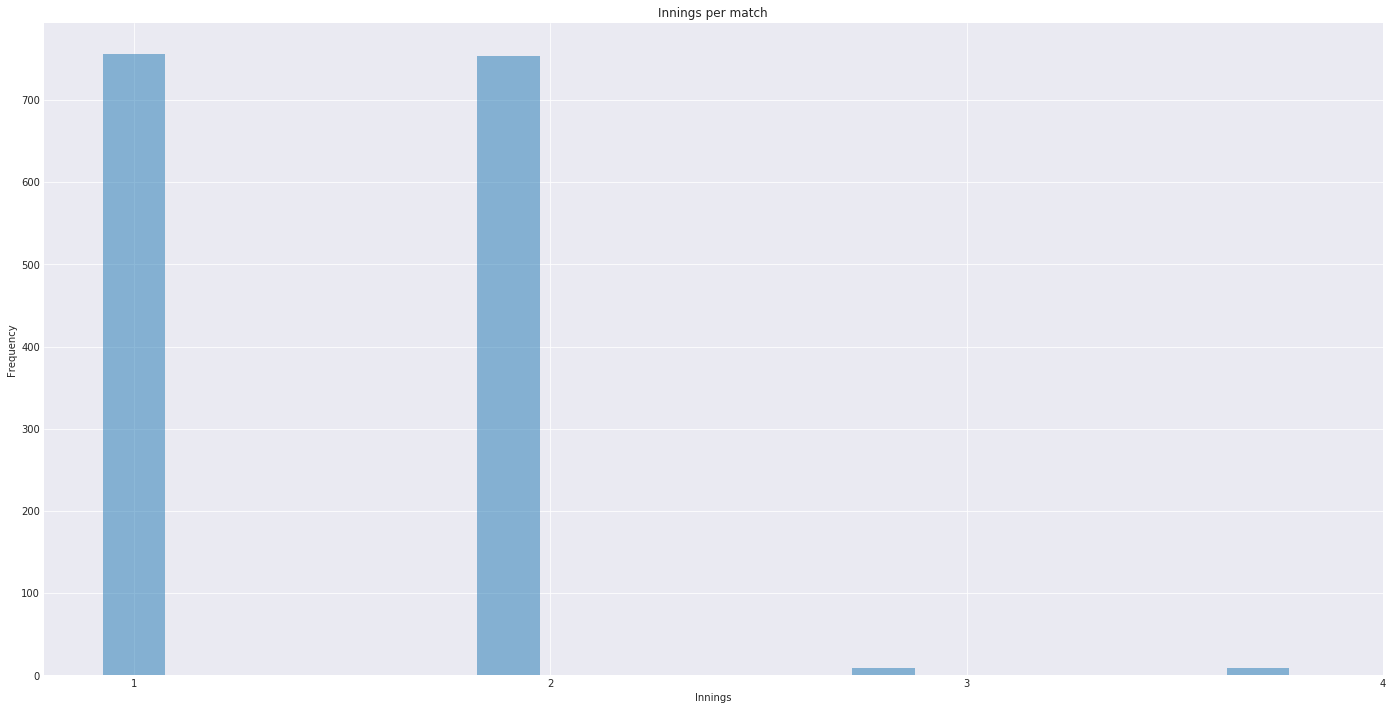

In [16]:
plt.title("Innings per match")
plt.hist(inningsInfo.InningNo, alpha=0.5, align="left", rwidth=0.5)
plt.xlabel("Innings")
plt.ylabel("Frequency")
plt.xticks(ticks=[1, 2, 3, 4])
plt.show()

## Remove Outlier Innings <a class="anchor" id="Remove-Outlier-Innings"></a>
We remove 3rd and 4th innings as those are oh only 1 over each.

In [17]:
inningsInfo = inningsInfo[inningsInfo.InningNo < 3]

## Remove Outlier No-Results <a class="anchor" id="Remove-Outlier-No-Results"></a>
Remove innins from no-result matches those not played for full overs and do not have results

In [18]:
inningsInfo = inningsInfo[inningsInfo.Winner != "no result"]

## Scatter-Plot Scores Per Innings <a class="anchor" id="Scatter-Plot-Scores-Per-Innings"></a>
Plot scatter for scores per innings by seasons

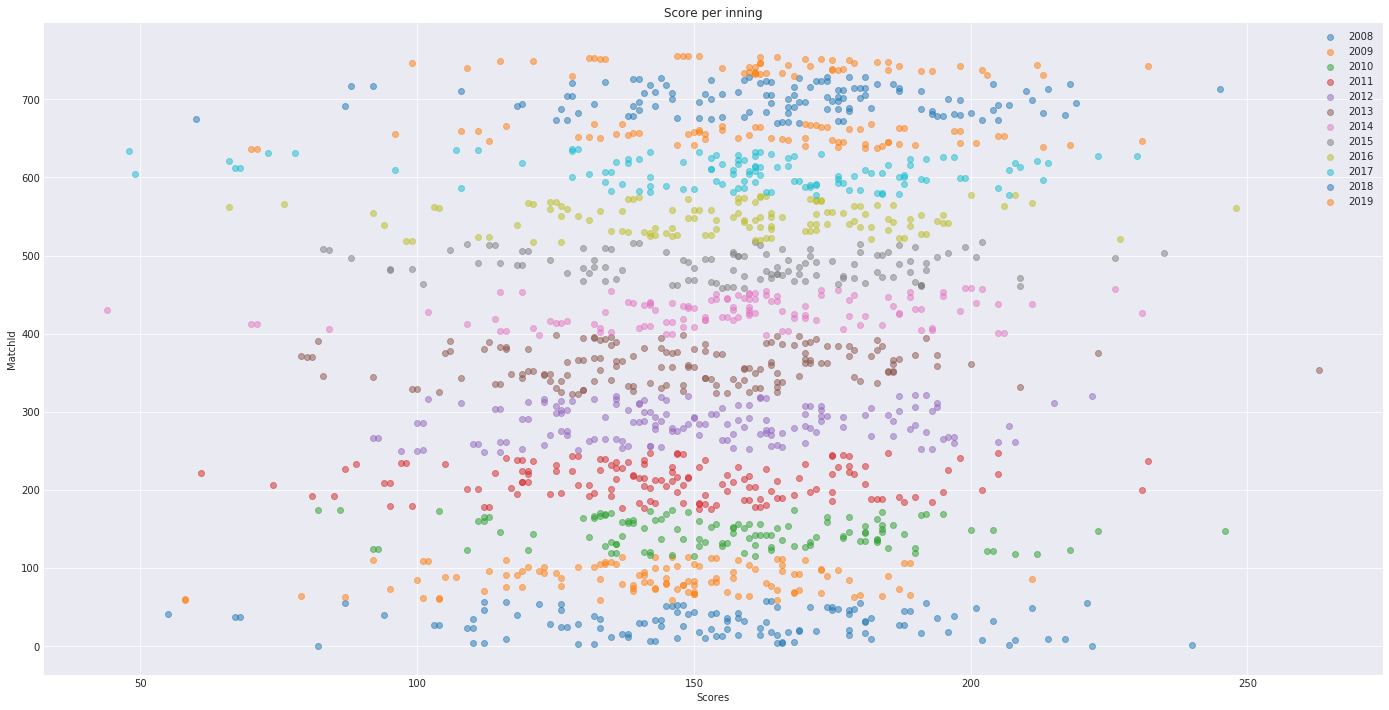

In [19]:
plt.title("Score per inning")
seasons = inningsInfo.Season.unique()
seasons.sort()
for season in seasons:
    innForSeason = inningsInfo[inningsInfo.Season == season]
    plt.scatter(
        innForSeason.teamTotalRuns, innForSeason.MatchId, alpha=0.5, label=season
    )

plt.legend()
plt.xlabel("Scores")
plt.ylabel("MatchId")
# plt.legend(inningsInfo.Season.unique())
plt.show()

In [20]:
inningsInfo.groupby("Season").mean()["teamTotalRuns"]

Season
2008    154.629310
2009    143.157895
2010    157.200000
2011    146.513889
2012    151.709459
2013    148.296053
2014    157.575000
2015    157.394737
2016    157.183333
2017    159.059322
2018    165.841667
2019    163.533898
Name: teamTotalRuns, dtype: float64

From this scatter plot we can conclude that avg score are increasing by each season, mean stats also shows same.

## Histogram Mumbai-Indians All Seasons <a class="anchor" id="Histogram-Mumbai-Indians-All-Seasons"></a>

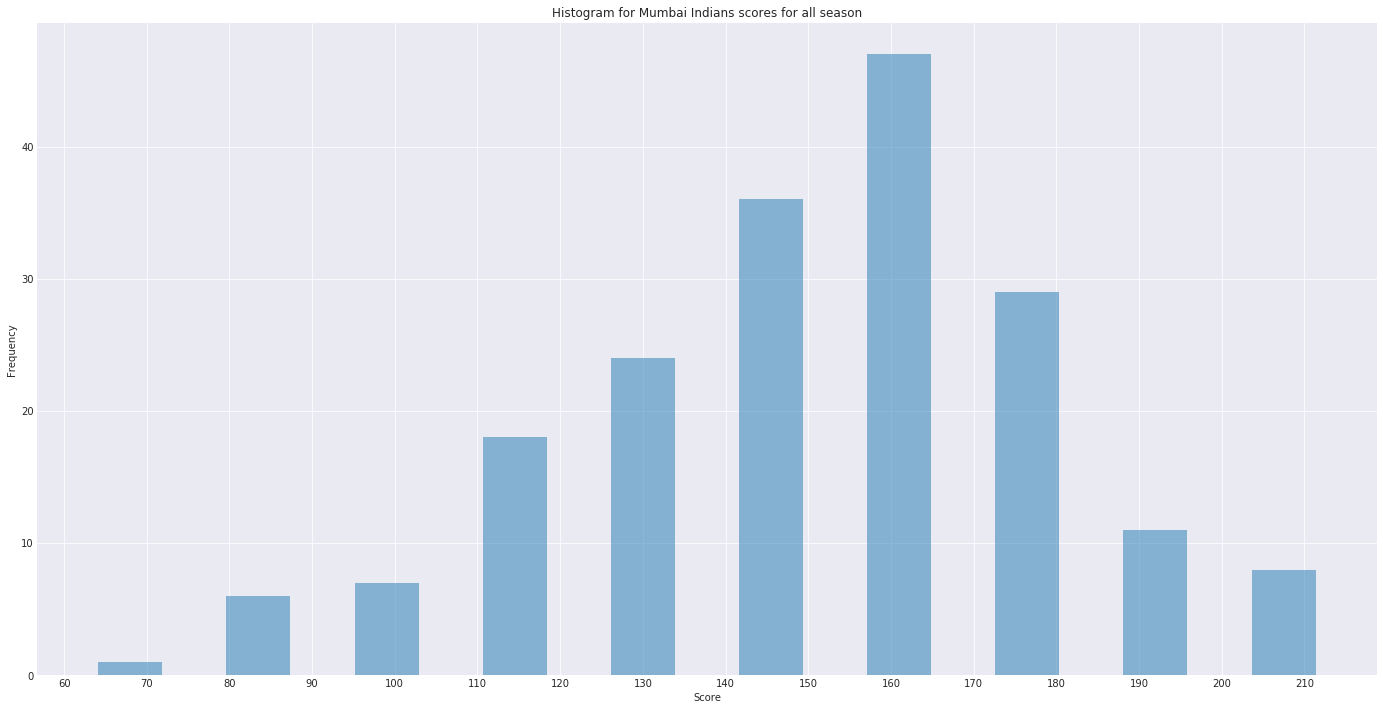

In [21]:
innForMI = inningsInfo[inningsInfo.BattingTeam == "Mumbai Indians"]
plt.hist(innForMI.teamTotalRuns, alpha=0.5, align="left", rwidth=0.5)
plt.plot()
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram for Mumbai Indians scores for all season")
plt.xticks(range(60, 220, 10))
plt.show()

This histogram shows Mumbai Indian scores mostly 160 runs per innings.

## Histogram Other Teams All Seasons <a class="anchor" id="Histogram-Other_Teams-All-Seasons"></a>

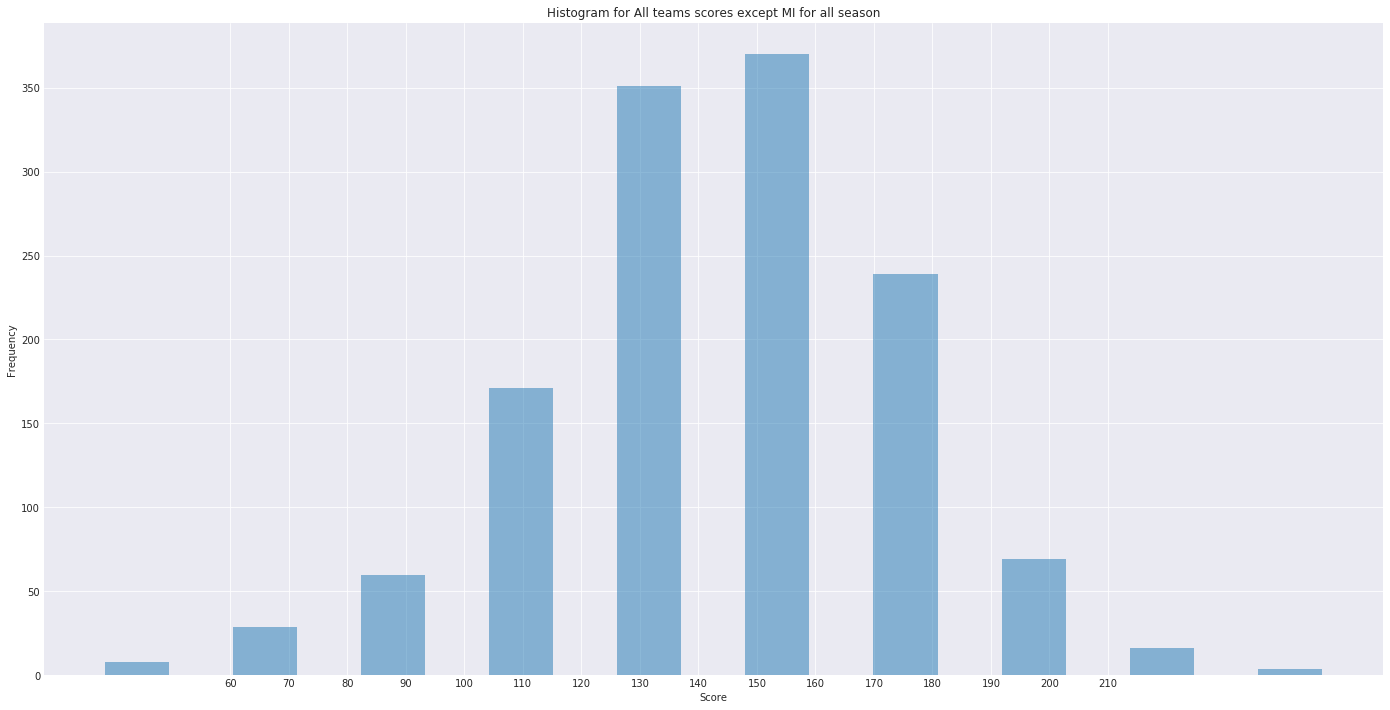

In [22]:
innForExceMI = inningsInfo[inningsInfo.BattingTeam != "Mumbai Indians"]
plt.hist(innForExceMI.teamTotalRuns, alpha=0.5, align="left", rwidth=0.5)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram for All teams scores except MI for all season")
plt.xticks(range(60, 220, 10))
plt.show()

Above histograms shows other teams schores more in range of 150 runs per innings

## Comparison with PMF <a class="anchor" id="Comparison-with-PMF"></a>
Compare score per innings Mumbai indians vs. Other teams.### Compare PMF for scores Mumbai Indians with others

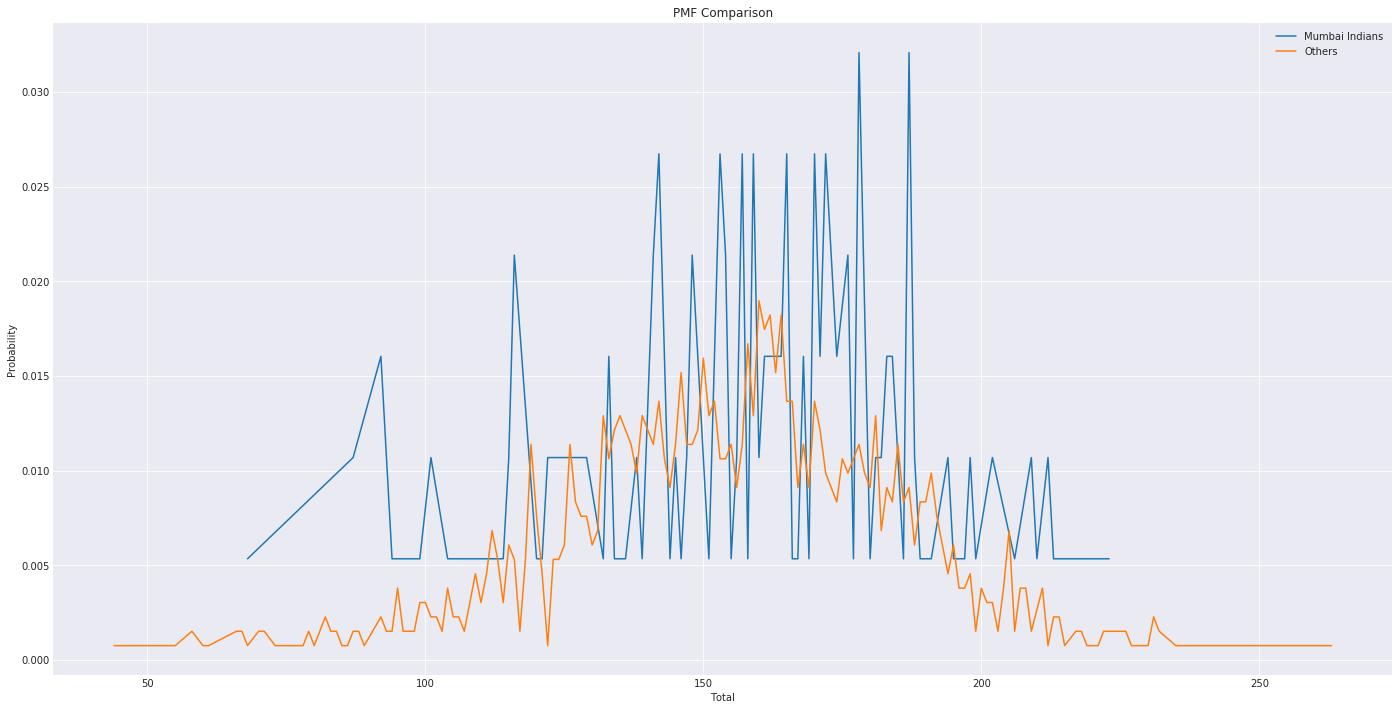

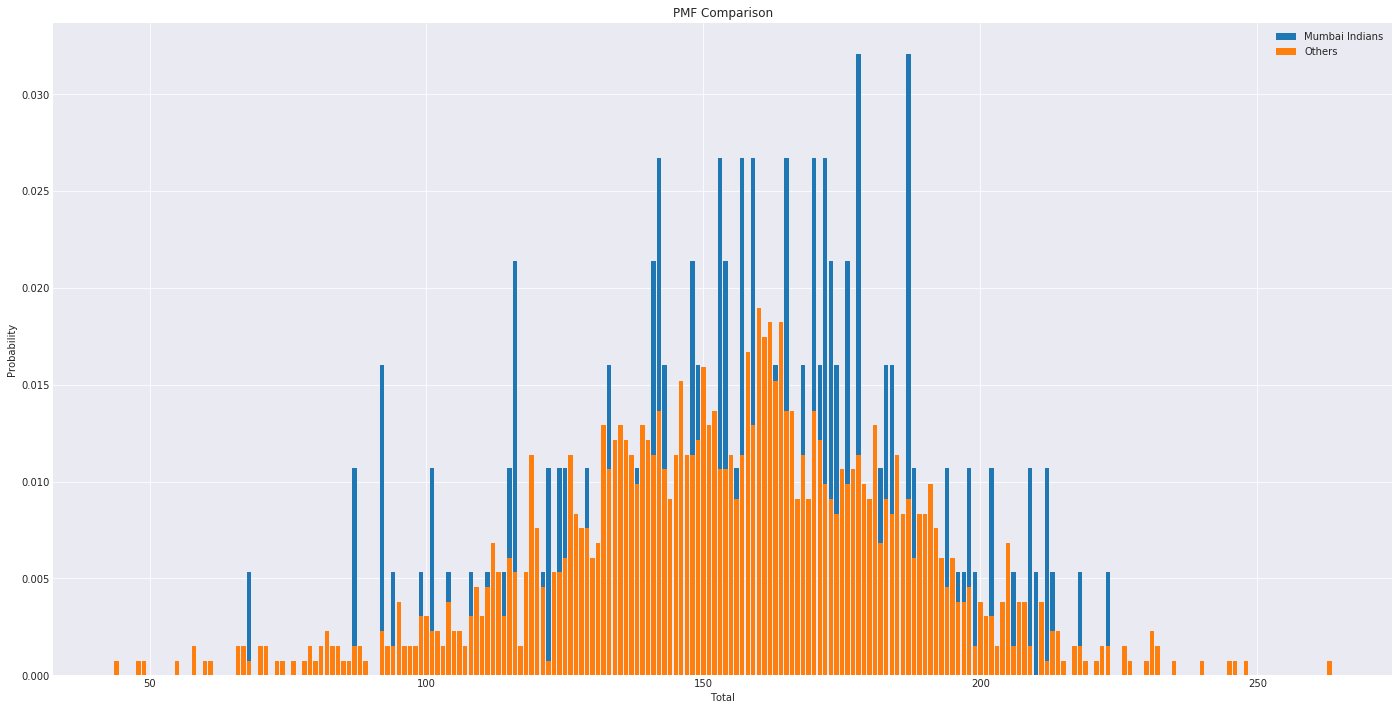

In [23]:
pmfMi = pmfcdf.Pmf(innForMI.teamTotalRuns)
pmfMi.normalize()
xs, ys = pmfMi.render()
pmfExcMi = pmfcdf.Pmf(innForExceMI.teamTotalRuns)
pmfExcMi.normalize()
xsExc, ysExc = pmfExcMi.render()

# Line plot
plt.plot(xs, ys, label="Mumbai Indians")
plt.plot(xsExc, ysExc, label="Others")
plt.xlabel("Total")
plt.ylabel("Probability")
plt.title("PMF Comparison")
plt.legend()
plt.show()

# Bar chart
plt.bar(xs, ys, label="Mumbai Indians")
plt.bar(xsExc, ysExc, label="Others")
plt.xlabel("Total")
plt.ylabel("Probability")
plt.title("PMF Comparison")
plt.legend()
plt.show()

### Comparison of Mumbia Indian Scors with Others

In [24]:
print(
    f"Mean Mumbia Indian Score: %0.2f \t Mean Other teams Score: %0.2f"
    % (innForMI.teamTotalRuns.mean(), innForExceMI.teamTotalRuns.mean())
)

Mean Mumbia Indian Score: 158.03 	 Mean Other teams Score: 154.40



## Comparison with CDF <a class="anchor" id="Comparison-with-CDF"></a>
Compare score per innings Mumbai indians vs. Other teams.


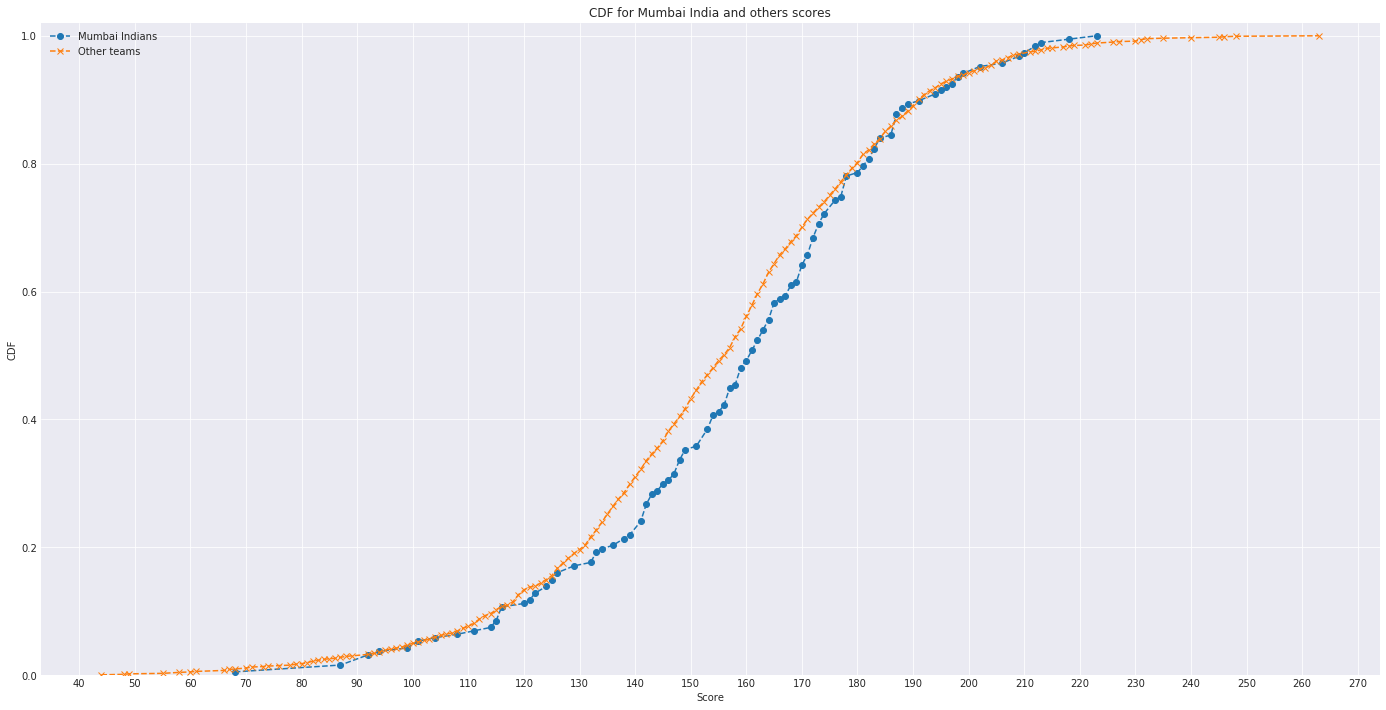

In [25]:
cdfMi, bin_edgesMi = pmfcdf.getCdf(innForMI.teamTotalRuns)
cdfOther, bin_edgesOthers = pmfcdf.getCdf(innForExceMI.teamTotalRuns)

# Plot the cdf
plt.plot(bin_edgesMi[0:-1], cdfMi, linestyle="--", marker="o", label="Mumbai Indians")
plt.plot(
    bin_edgesOthers[0:-1], cdfOther, linestyle="--", marker="x", label="Other teams"
)

plt.ylim((0, 1.02))
plt.ylabel("CDF")
plt.xlabel("Score")
plt.title("CDF for Mumbai India and others scores")
plt.legend()
plt.xticks(range(40, 271, 10))
plt.show()

Above figure shows that Mumbai indians has slighlty better scores arund 130 to 185 compared to other teams

## Normal Distribution CDF Comparison <a class="anchor" id="Normal-Distribution-CDF-Comparison"></a>
Comparison of Mumbia Indians and other teams with normal dstribution by finding out mu and sigma.

Normal Distribution for MI Mean:158.03	Var:838.68	Sigma:28.96
Normal Distribution for Others Mean:154.40	Var:968.54	Sigma:31.12


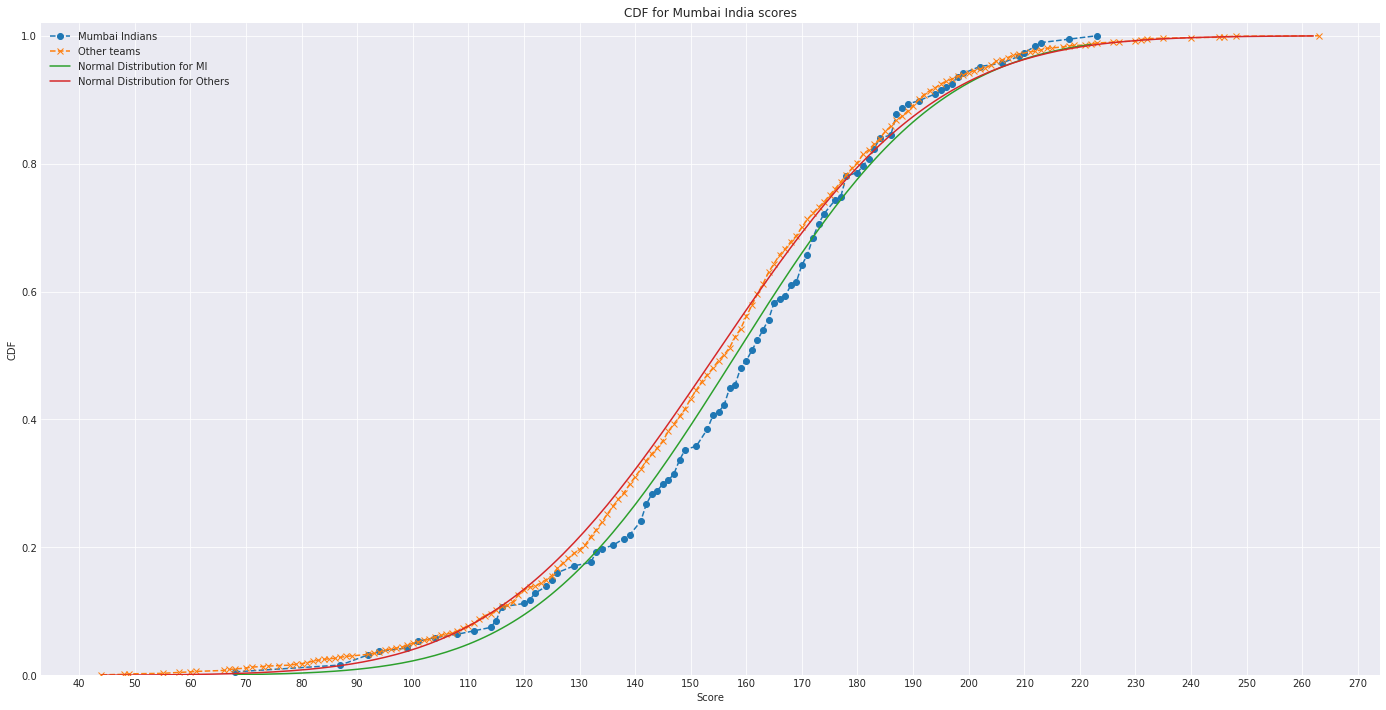

In [26]:
def plotnormalDistribution(dataset, label):
    xs = np.asarray(dataset)
    mu = xs.mean()
    ds = xs - mu
    var = np.dot(ds, ds) / (len(xs) - 0)
    sigma = np.sqrt(var)
    print(f"%s Mean:%0.2f\tVar:%0.2f\tSigma:%0.2f" % (label, mu, var, sigma))
    x = range(int(dataset.min()), int(dataset.max()))
    y = scistats.norm.cdf(x, mu, sigma)
    plt.plot(x, y, label=label)


cdfMi, bin_edgesMi = pmfcdf.getCdf(innForMI.teamTotalRuns)
cdfOther, bin_edgesOthers = pmfcdf.getCdf(innForExceMI.teamTotalRuns)

# Plot the cdf
plt.plot(bin_edgesMi[0:-1], cdfMi, linestyle="--", marker="o", label="Mumbai Indians")
plt.plot(
    bin_edgesOthers[0:-1], cdfOther, linestyle="--", marker="x", label="Other teams"
)
plotnormalDistribution(innForMI.teamTotalRuns, "Normal Distribution for MI")
plotnormalDistribution(innForExceMI.teamTotalRuns, "Normal Distribution for Others")

plt.ylim((0, 1.02))
plt.ylabel("CDF")
plt.xlabel("Score")
plt.title("CDF for Mumbai India scores")
plt.legend()
plt.xticks(range(40, 271, 10))
plt.show()

## Scatter-Plot Opener Contribution <a class="anchor" id="Scatter-Plot-Opener-Contribution"></a>
Compare opener batsman score with total team scores by innings, color by match result.</br>
Find correlation matrix.

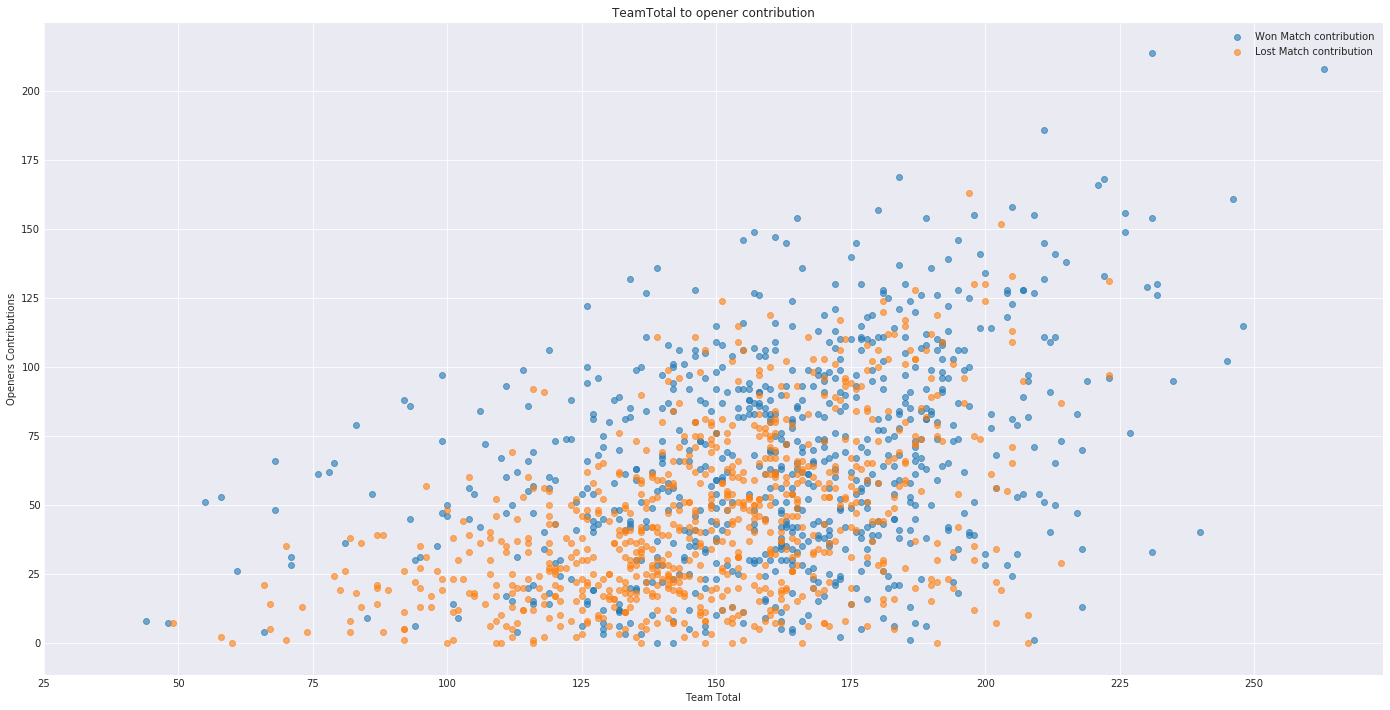

In [27]:
wonInns = inningsInfo[inningsInfo.Won == True]
lostInns = inningsInfo[inningsInfo.Won == False]
plt.scatter(
    wonInns.teamTotalRuns,
    wonInns.OpenersTotalRuns,
    alpha=0.6,
    label="Won Match contribution",
)
plt.scatter(
    lostInns.teamTotalRuns,
    lostInns.OpenersTotalRuns,
    alpha=0.6,
    label="Lost Match contribution",
)
plt.title("TeamTotal to opener contribution")
plt.xlabel("Team Total")
plt.ylabel("Openers Contributions")
plt.legend()
plt.xticks(range(25, 275, 25))
plt.yticks(range(0, 225, 25))
plt.show()

In [28]:
tempDf = pd.concat([inningsInfo.teamTotalRuns, inningsInfo.OpenersTotalRuns], axis=1)
print("Covariance", tempDf.cov(), end="\n\n")
print("Pearson Correlation", tempDf.corr(method="pearson"), end="\n\n")

pbc = scistats.pointbiserialr(inningsInfo.OpenersTotalRuns, inningsInfo.Won)
print(pbc)

Covariance                   teamTotalRuns  OpenersTotalRuns
teamTotalRuns        954.461770        501.838433
OpenersTotalRuns     501.838433       1266.492625

Pearson Correlation                   teamTotalRuns  OpenersTotalRuns
teamTotalRuns           1.00000           0.45644
OpenersTotalRuns        0.45644           1.00000

PointbiserialrResult(correlation=0.3064424433593573, pvalue=4.583588404215659e-34)


Correlation between teamTotal and Opener Batsmans contribution</br>
We also have correlation between Openers contribution and the winning and losing, p-value confirm this relation by rejecting null hypothesis


## Scatter-Plot First Six Overs Score <a class="anchor" id="Scatter-Plot-First-Six-Overs-Score"></a>
Compare First 6 overs score with total team scores by innings, color by match result.</br>
Find correlation matrix.

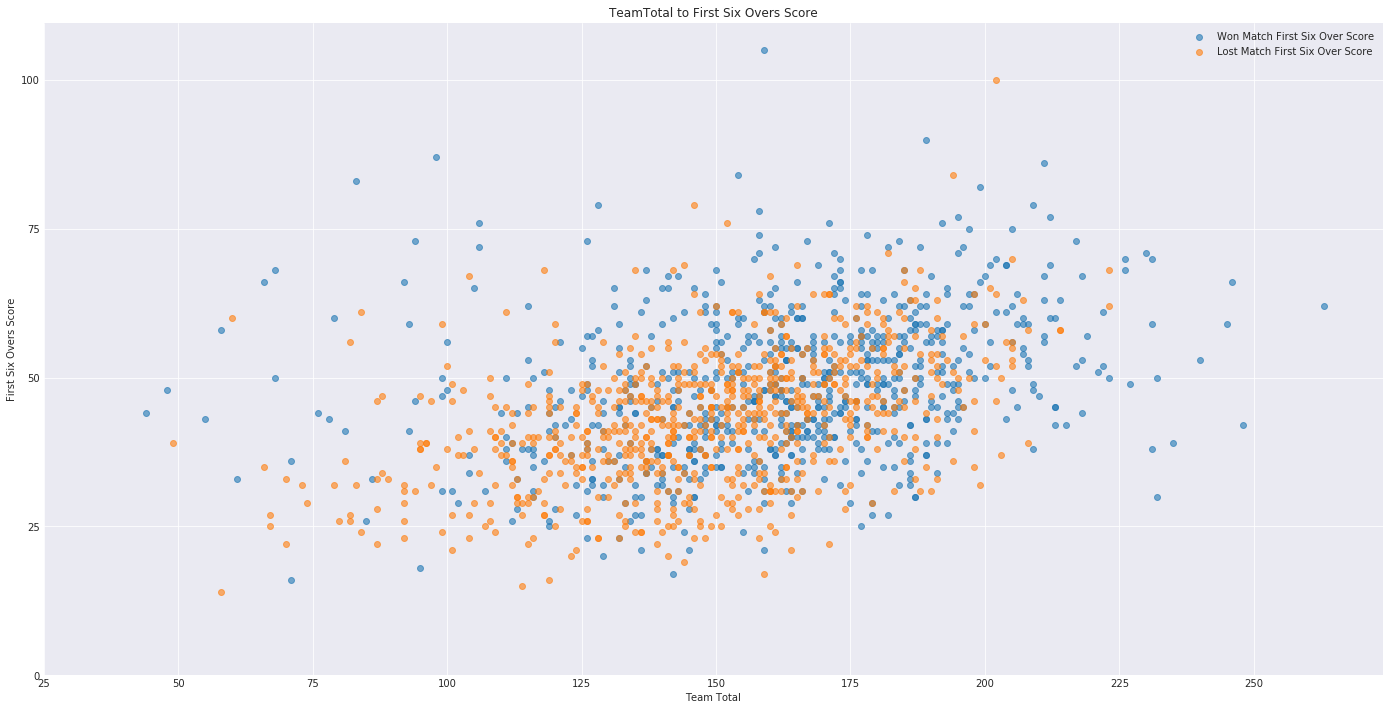

In [29]:
plt.scatter(
    wonInns.teamTotalRuns,
    wonInns.firstSixTotal,
    alpha=0.6,
    label="Won Match First Six Over Score",
)
plt.scatter(
    lostInns.teamTotalRuns,
    lostInns.firstSixTotal,
    alpha=0.6,
    label="Lost Match First Six Over Score",
)
plt.title("TeamTotal to First Six Overs Score")
plt.xlabel("Team Total")
plt.ylabel("First Six Overs Score")
plt.legend()
plt.xticks(range(25, 275, 25))
plt.yticks(range(0, 125, 25))
plt.show()

In [30]:
tempDf = pd.concat([inningsInfo.teamTotalRuns, inningsInfo.firstSixTotal], axis=1)
print("Covariance", tempDf.cov(), end="\n\n")
print("Pearson Correlation", tempDf.corr(method="pearson"), end="\n\n")

pbc = scistats.pointbiserialr(inningsInfo.firstSixTotal, inningsInfo.Won)
print(pbc)

Covariance                teamTotalRuns  firstSixTotal
teamTotalRuns      954.46177     147.381050
firstSixTotal      147.38105     145.055839

Pearson Correlation                teamTotalRuns  firstSixTotal
teamTotalRuns       1.000000       0.396091
firstSixTotal       0.396091       1.000000

PointbiserialrResult(correlation=0.2283302908772324, pvalue=3.066031954648354e-19)


Above corretion numbers show we have positive relationship between first six overs score and total team score. 
Point biserial Correlation values shows positive relationship as well p-value rejects null hypothesis. 

## Scatter-Plot Last Five Overs Score <a class="anchor" id="Scatter-Plot-Last-Five-Overs-Score"></a>
Compare Last 5 overs score with total team scores by innings, color by match result.</br>
Find correlation matrix.

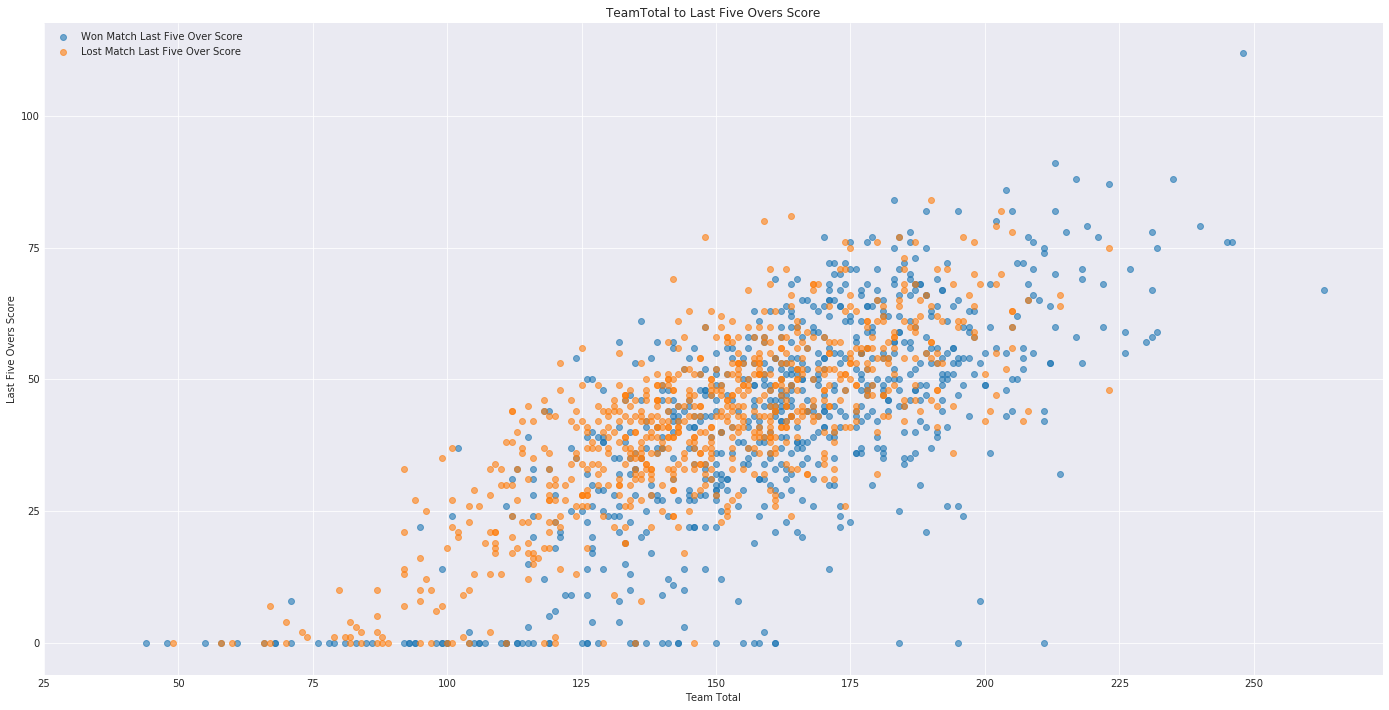

In [31]:
plt.scatter(
    wonInns.teamTotalRuns,
    wonInns.lastFiveTotal,
    alpha=0.6,
    label="Won Match Last Five Over Score",
)
plt.scatter(
    lostInns.teamTotalRuns,
    lostInns.lastFiveTotal,
    alpha=0.6,
    label="Lost Match Last Five Over Score",
)
plt.title("TeamTotal to Last Five Overs Score")
plt.xlabel("Team Total")
plt.ylabel("Last Five Overs Score")
plt.legend()
plt.xticks(range(25, 275, 25))
plt.yticks(range(0, 125, 25))
plt.show()

In [32]:
tempDf = pd.concat([inningsInfo.teamTotalRuns, inningsInfo.lastFiveTotal], axis=1)
print("Covariance", tempDf.cov(), end="\n\n")
print("Pearson Correlation", tempDf.corr(method="pearson"), end="\n\n")

pbc = scistats.pointbiserialr(inningsInfo.Won, inningsInfo.lastFiveTotal)
print(pbc)

Covariance                teamTotalRuns  lastFiveTotal
teamTotalRuns     954.461770     418.696843
lastFiveTotal     418.696843     348.678816

Pearson Correlation                teamTotalRuns  lastFiveTotal
teamTotalRuns       1.000000       0.725784
lastFiveTotal       0.725784       1.000000

PointbiserialrResult(correlation=0.026314742201529157, pvalue=0.30779881584986263)


Above corretion numbers show we have positive relationship between last five overs score and total team score. 
Point biserial Correlation values shows positive relationship however p-value is not rejecting null hypothesis as p-value is greater than 0.05. 

## Scatter-Plot Runs Conceded in First Six Overs <a class="anchor" id="Scatter-Plot-Runs-Conceded-in-First-Six-Overs"></a>
Compare how runs conceded in first 6 overs impact winning or losing

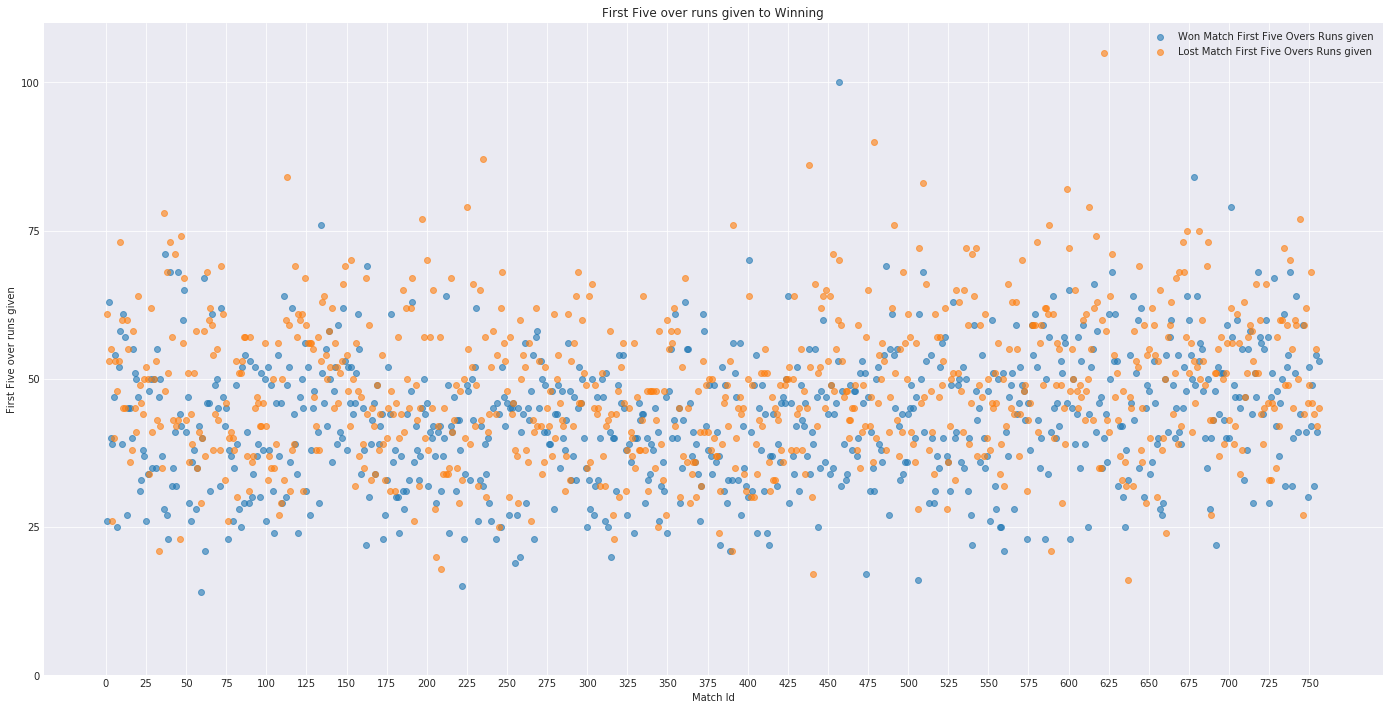

In [33]:
plt.scatter(
    wonInns.MatchId,
    wonInns.firstSixTotalGiven,
    alpha=0.6,
    label="Won Match First Five Overs Runs given",
)
plt.scatter(
    lostInns.MatchId,
    lostInns.firstSixTotalGiven,
    alpha=0.6,
    label="Lost Match First Five Overs Runs given",
)
plt.title("First Five over runs given to Winning")
plt.xlabel("Match Id")
plt.ylabel("First Five over runs given")
plt.legend()
plt.xticks(range(0, 760, 25))
plt.yticks(range(0, 125, 25))
plt.show()

In [34]:
pbc = scistats.pointbiserialr(inningsInfo.firstSixTotalGiven, inningsInfo.Won)
print(pbc)

PointbiserialrResult(correlation=-0.22498194053040915, pvalue=1.0344301557061923e-18)


Above corretion numbers show we have negative relationship between first six overs runs given to oppenent and winning and losing. 
P-value is rejecting null hypothesis as p-value is very small. 

## Scatter-Plot Runs Conceded in Last Five Overs <a class="anchor" id="Scatter-Plot-Runs-Conceded-in-Last-Five-Overs"></a>
Compare how runs conceded in last 5 overs impact winning or losingovers

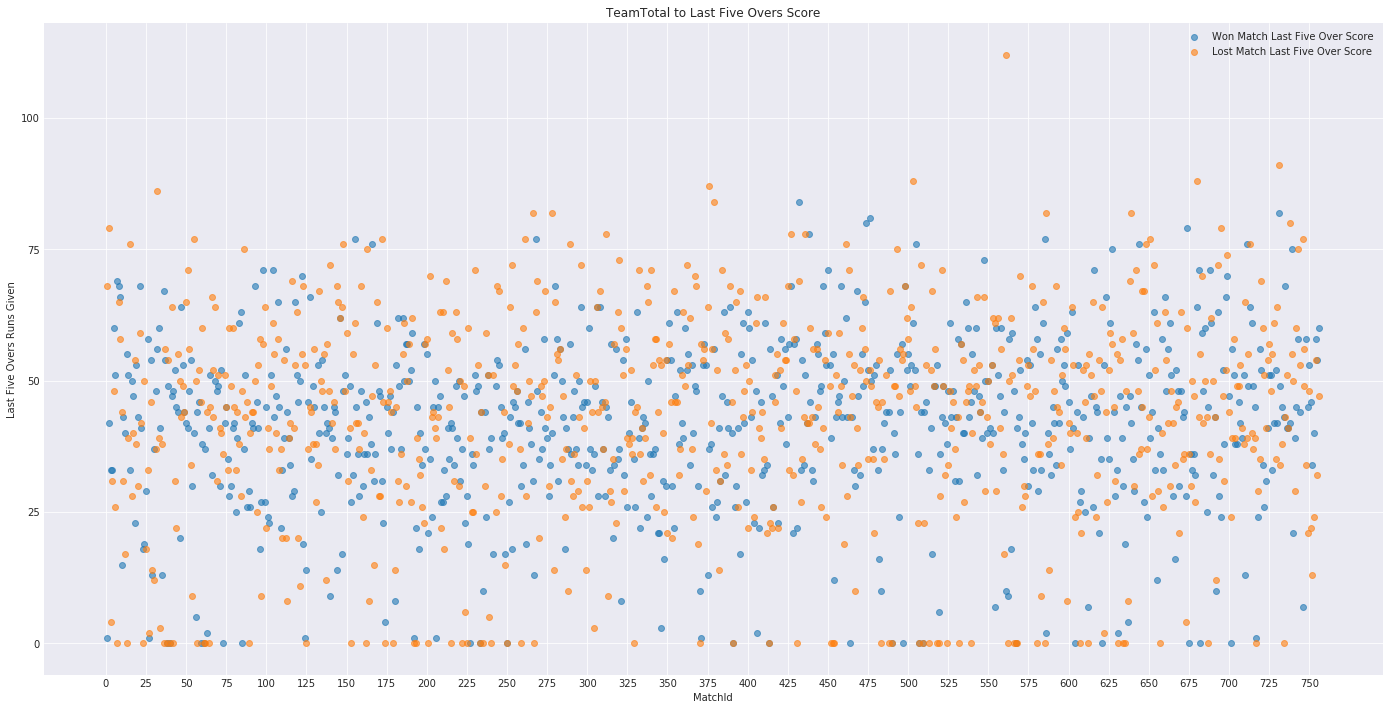

In [35]:
plt.scatter(
    wonInns.MatchId,
    wonInns.lastFiveTotalGiven,
    alpha=0.6,
    label="Won Match Last Five Over Score",
)
plt.scatter(
    lostInns.MatchId,
    lostInns.lastFiveTotalGiven,
    alpha=0.6,
    label="Lost Match Last Five Over Score",
)
plt.title("TeamTotal to Last Five Overs Score")
plt.xlabel("MatchId")
plt.ylabel("Last Five Overs Runs Given")
plt.legend()
plt.xticks(range(0, 760, 25))
plt.yticks(range(0, 125, 25))
plt.show()

In [36]:
pbc = scistats.pointbiserialr(inningsInfo.lastFiveTotalGiven, inningsInfo.Won)
print(pbc)

PointbiserialrResult(correlation=-0.03338726466980052, pvalue=0.19563420150438063)


Above numbers shows that the relationship is very weak also p-value indicates the null hypothesis is not false

## Hypothesis Test <a class="anchor" id="Hypothesis-Test"></a>
Virat Kohli scores more runs in second innings ?

Observer Difference:5.76
PValue:0.16


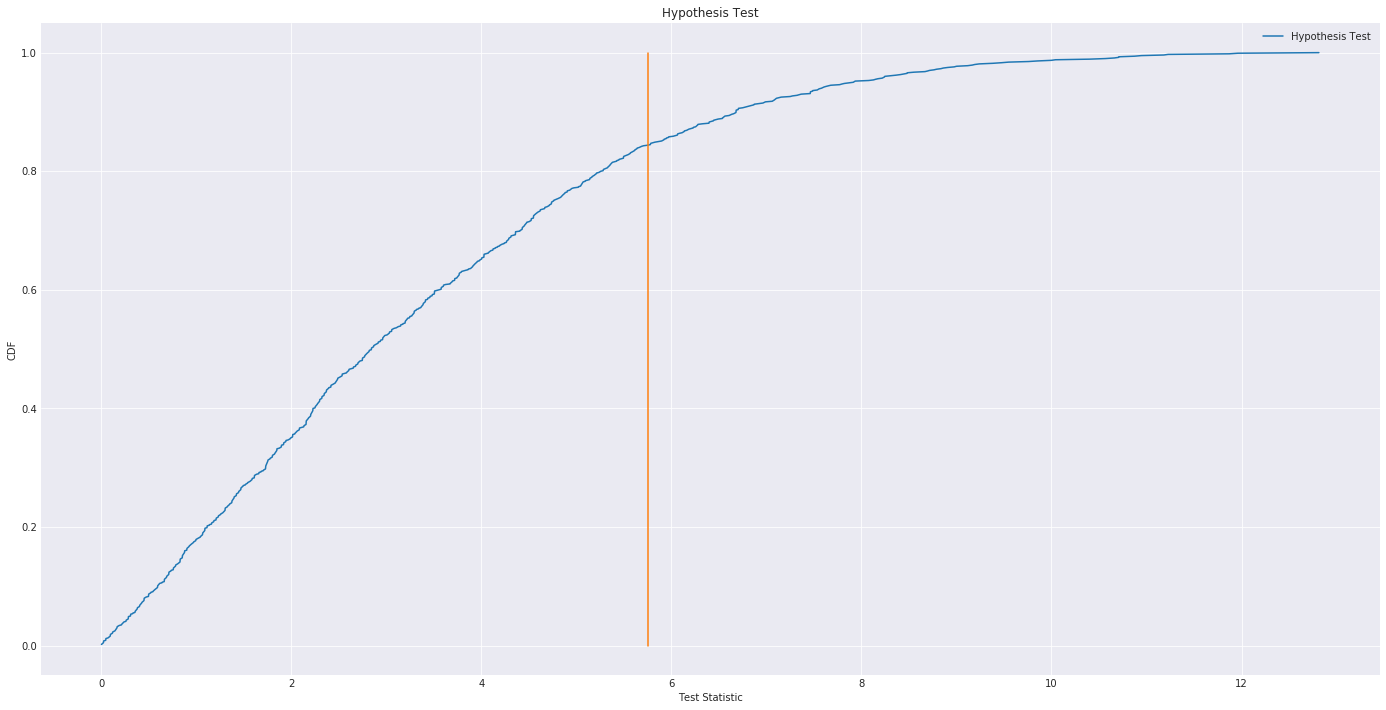

In [37]:
allVKScores = batsmanPerMatch[batsmanPerMatch.Batsman == "V Kohli"]
vkFirstInningsScores = allVKScores[allVKScores.InningNo == 1].TotalRuns.values
vkSecondInningsScores = allVKScores[allVKScores.InningNo == 2].TotalRuns.values
obs_diff = abs(vkFirstInningsScores.mean() - vkSecondInningsScores.mean())
print(f"Observer Difference:%0.2f" % obs_diff)

groups = vkFirstInningsScores, vkSecondInningsScores

ht = hptest.ClassicHypothesisTest(groups)
pv = ht.PValue()
print(f"PValue:%0.2f" % pv)


cdfHt, bin_edgesMi = pmfcdf.getCdf(ht.test_stats)

# Plot the cdf
plt.plot(bin_edgesMi[0:-1], cdfHt, label="Hypothesis Test")
plt.plot([obs_diff, obs_diff], [0, 1])
plt.title("Hypothesis Test")
plt.xlabel("Test Statistic")
plt.ylabel("CDF")
plt.legend()
plt.show()

The PValue is 0.16, that indicates that we can expect the difference between 2 innings score as big as the observed difference 5.76 16% of times.</br> 
So from this we can conclude that this effect is not statistically significant. The CDF interesects at 0.84 which is complement of the Pvalue 0.16.

## Logistic Regression <a class="anchor" id="Logistic-Regression"></a>
How different attributes impact winning.</br> Find Correlations for columns.

In [38]:
columnsNames = [
    "BattingTeam",
    "opposition",
    "City",
    "Chasing",
    "WonToss",
    "teamTotalRuns",
    "OpenersTotalRuns",
    "boundries",
    "firstSixTotal",
    "lastFiveTotal",
    "boundriesGiven",
    "firstSixTotalGiven",
    "lastFiveTotalGiven",
    "oppisitionTotalRuns",
]


for column in columnsNames:
    print("Correlation for:", column, " With Column Won")
    print(cc.theils_u(inningsInfo.Won, inningsInfo[column]))

Correlation for: BattingTeam  With Column Won
0.0170829596509302
Correlation for: opposition  With Column Won
0.01823727482468467
Correlation for: City  With Column Won
0.0004147545228560061
Correlation for: Chasing  With Column Won
0.00838744106092168
Correlation for: WonToss  With Column Won
0.0013898995082461216
Correlation for: teamTotalRuns  With Column Won
0.15013965053024567
Correlation for: OpenersTotalRuns  With Column Won
0.15514479951661883
Correlation for: boundries  With Column Won
0.08113799579311623
Correlation for: firstSixTotal  With Column Won
0.07475507117224245
Correlation for: lastFiveTotal  With Column Won
0.061600569460932154
Correlation for: boundriesGiven  With Column Won
0.08034421364316711
Correlation for: firstSixTotalGiven  With Column Won
0.0743562304391498
Correlation for: lastFiveTotalGiven  With Column Won
0.06079928227100333
Correlation for: oppisitionTotalRuns  With Column Won
0.1477723753520669


We will consider only columns with correlation >= .10</br>
Following columns we will use</br>
* teamTotalRuns
* OpenersTotalRuns</br>
* oppositionTotalRuns</br>

## Fitting model with all data <a class="anchor" id="Fitting-model-with-all-data"></a>
Create model with all the data from innigns information dataframe with above columns.

In [39]:
inningsInfo["WonAsInt"] = inningsInfo.Won.astype("int")
formula = "WonAsInt ~ teamTotalRuns + OpenersTotalRuns + oppisitionTotalRuns"
model = smf.logit(formula, data=inningsInfo)

## Model Accuracy with all data <a class="anchor" id="Model-Accuracy-with-all-data"></a>

In [40]:
def printModelAndAccuracy(regModel, testDataset):
    results = regModel.fit()
    print(results.params)
    endog = pd.DataFrame(regModel.endog, columns=[regModel.endog_names])
    exog = pd.DataFrame(regModel.exog, columns=regModel.exog_names)

    actual = testDataset["WonAsInt"]
    baseline = actual.mean()

    lengthTest = len(actual)
    predict = results.predict(testDataset) >= 0.5
    true_pos = predict * actual
    true_neg = (1 - predict) * (1 - actual)
    sumTp = sum(true_pos)
    sumTn = sum(true_neg)
    print(
        "True Positives:%0.0f \t True Negatives:%0.0f \t Length Test Dataset:%d"
        % (sumTp, sumTn, lengthTest)
    )
    acc = (sumTp + sumTn) / lengthTest
    print(f"Accuracy:%0.2f%%" % acc)


printModelAndAccuracy(model, inningsInfo)

Optimization terminated successfully.
         Current function value: 0.463738
         Iterations 8
Intercept              0.264526
teamTotalRuns          0.120727
OpenersTotalRuns       0.015821
oppisitionTotalRuns   -0.128434
dtype: float64
True Positives:628 	 True Negatives:671 	 Length Test Dataset:1504
Accuracy:0.86%


The Accuracy for model with same training and test dataset is 86 %

### Model fit with Splitting training and test dataset 70-30%

In [41]:
modelDataset = pd.DataFrame.copy(inningsInfo)
trainingSet = modelDataset.sample(frac=0.70, random_state=0)
testSet = modelDataset.drop(trainingSet.index)

## Model Accuracy with split data <a class="anchor" id="Model-Accuracy-with-split-data"></a>
Create model by splitting data into 70-30 training dataset and test dataset from innigns information dataframe with above columns.

In [42]:
model = smf.logit(formula, data=trainingSet)
printModelAndAccuracy(model, testSet)

Optimization terminated successfully.
         Current function value: 0.473392
         Iterations 8
Intercept              0.143369
teamTotalRuns          0.113018
OpenersTotalRuns       0.014804
oppisitionTotalRuns   -0.119837
dtype: float64
True Positives:196 	 True Negatives:201 	 Length Test Dataset:451
Accuracy:0.88%


With splitting data into training and test dataset the accuracy is 88%

## Histogram Matches Per Season <a class="anchor" id="Histogram-Matches-Per-Season"></a>

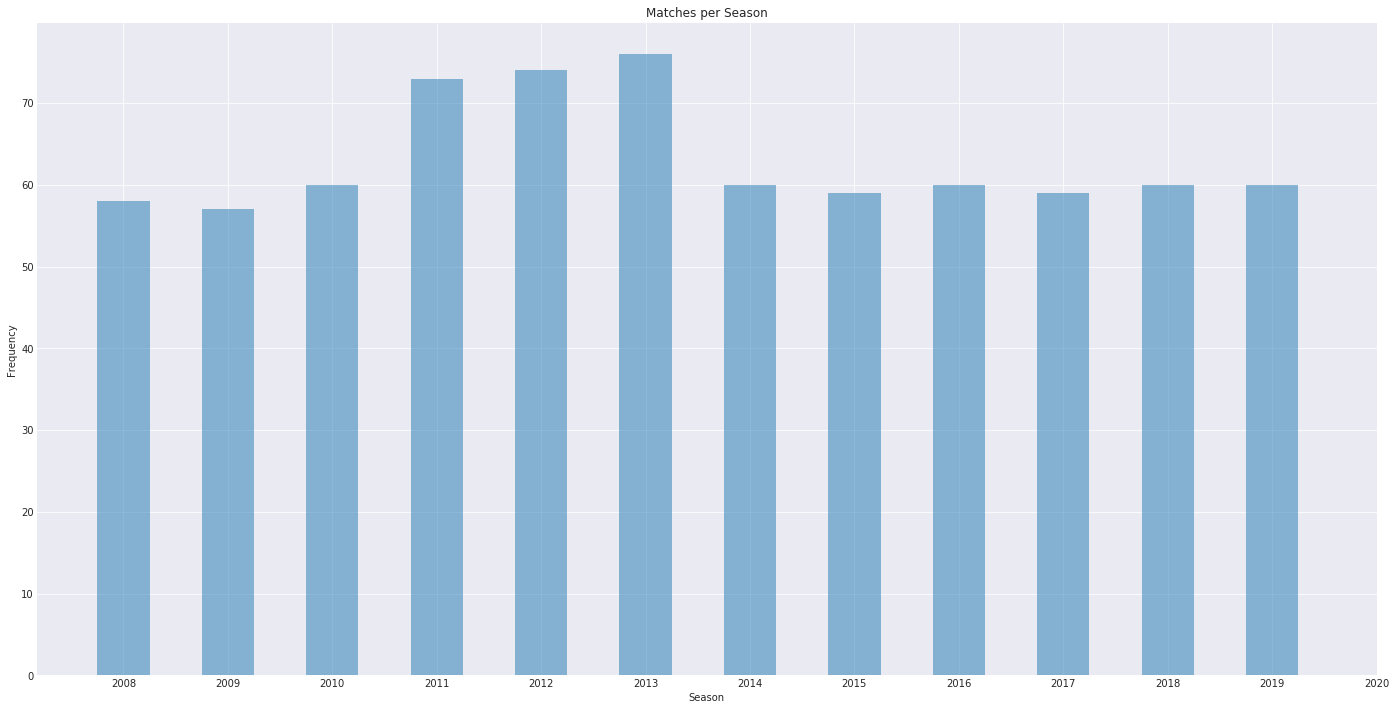

In [43]:
bins = list(range(2008, 2021))
plt.title("Matches per Season")
plt.hist(dfMatchInfo.Season, bins=bins, alpha=0.5, align="left", rwidth=0.5)
plt.xlabel("Season")
plt.ylabel("Frequency")
plt.xticks(ticks=bins)
plt.show()

## Histogram Matches Per Location <a class="anchor" id="Histogram-Matches-Per-Location"></a>

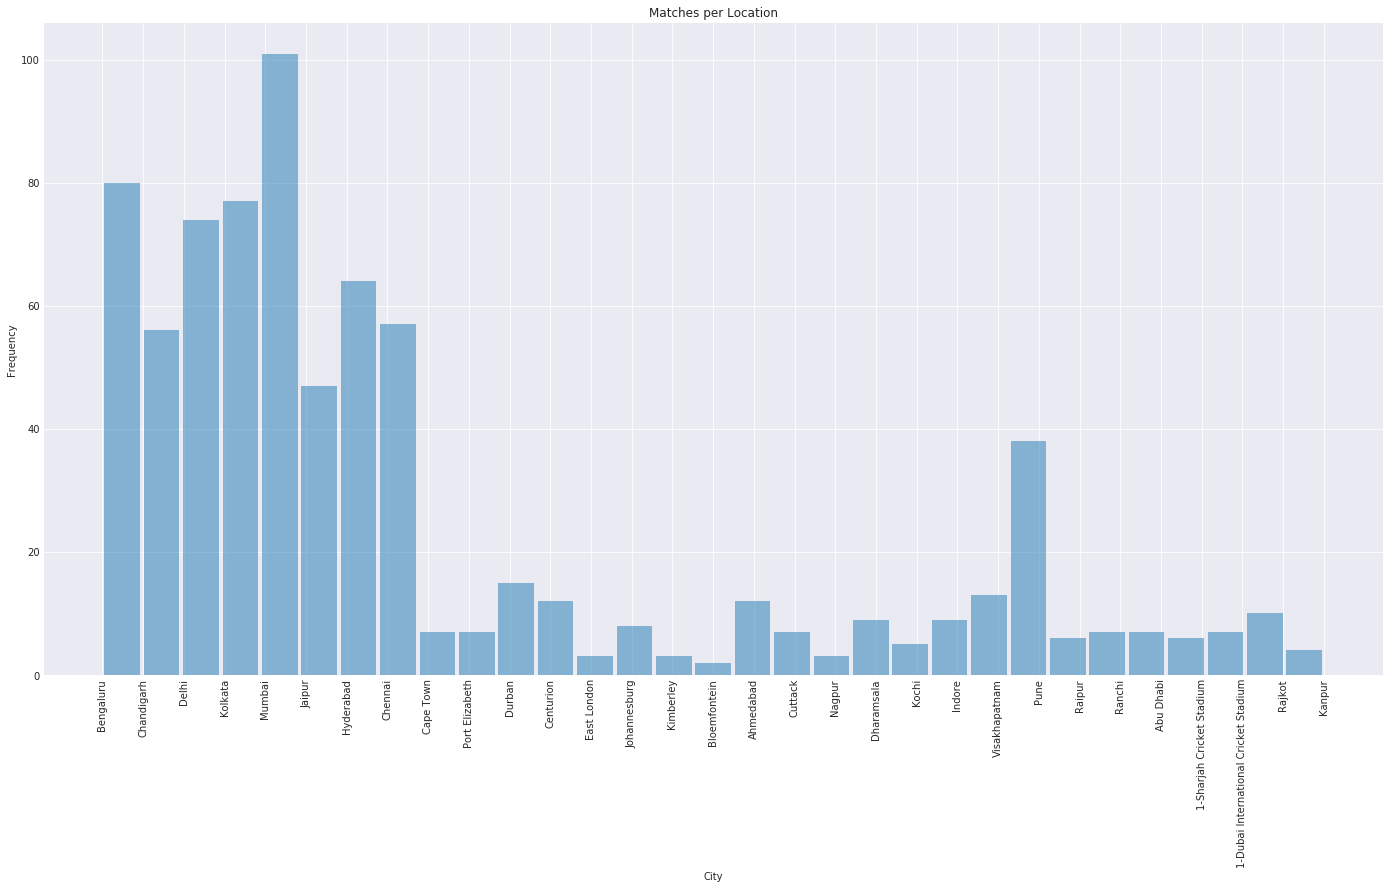

In [44]:
cities = len(dfMatchInfo.City.unique())
plt.title("Matches per Location")
plt.hist(dfMatchInfo.City, bins=cities, alpha=0.5, align="mid", rwidth=0.9)
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

## Histogram For Toss Winners <a class="anchor" id="Histogram-For-Toss-Winners"></a>

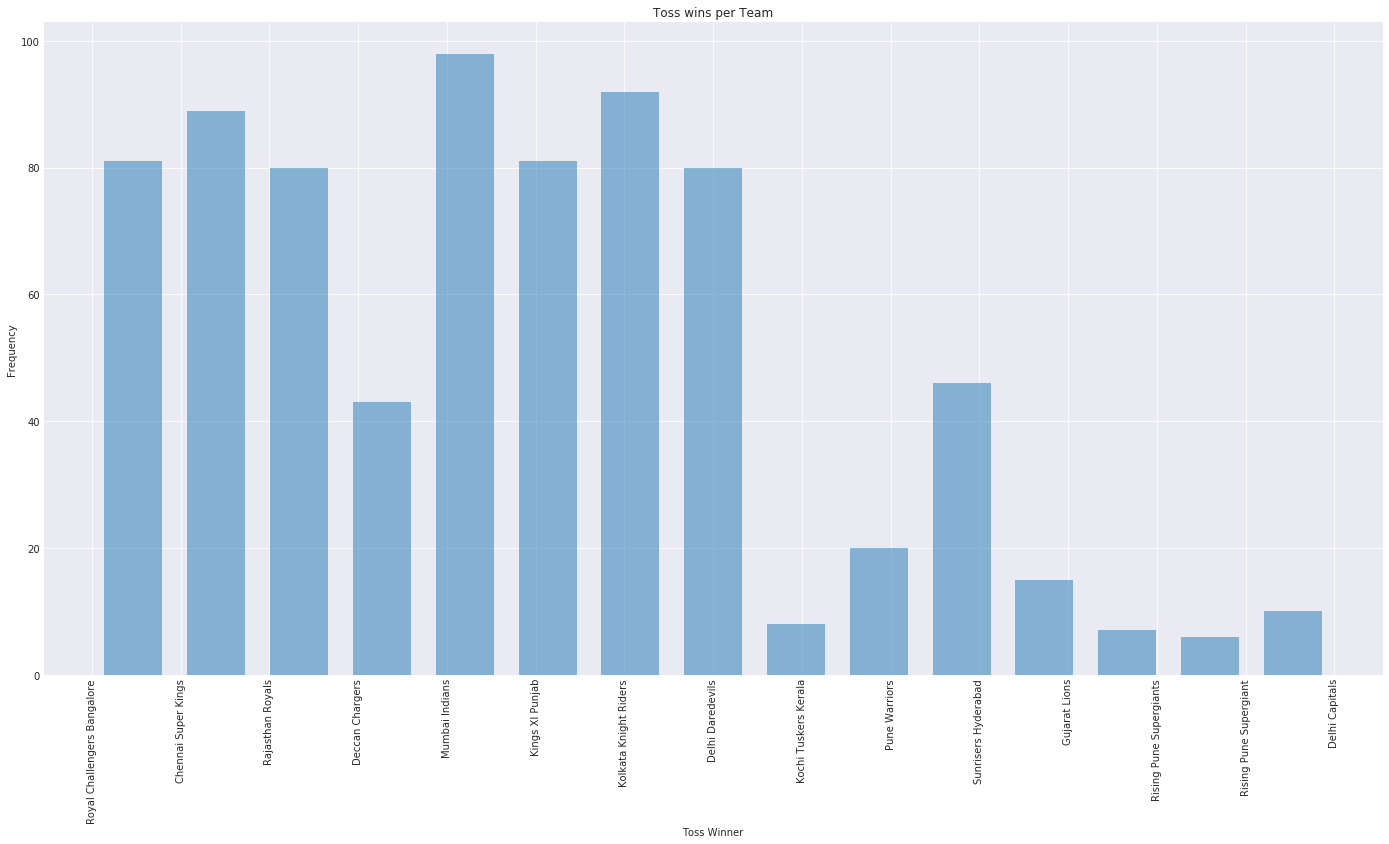

In [45]:
bins = len(dfMatchInfo.TossWinner.unique())
plt.title("Toss wins per Team")
plt.hist(
    dfMatchInfo.TossWinner, bins=bins, alpha=0.5, align="mid", rwidth=0.7,
)
plt.xlabel("Toss Winner")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

## Histogram For Match Winners <a class="anchor" id="Histogram-For-Match-Winners"></a>

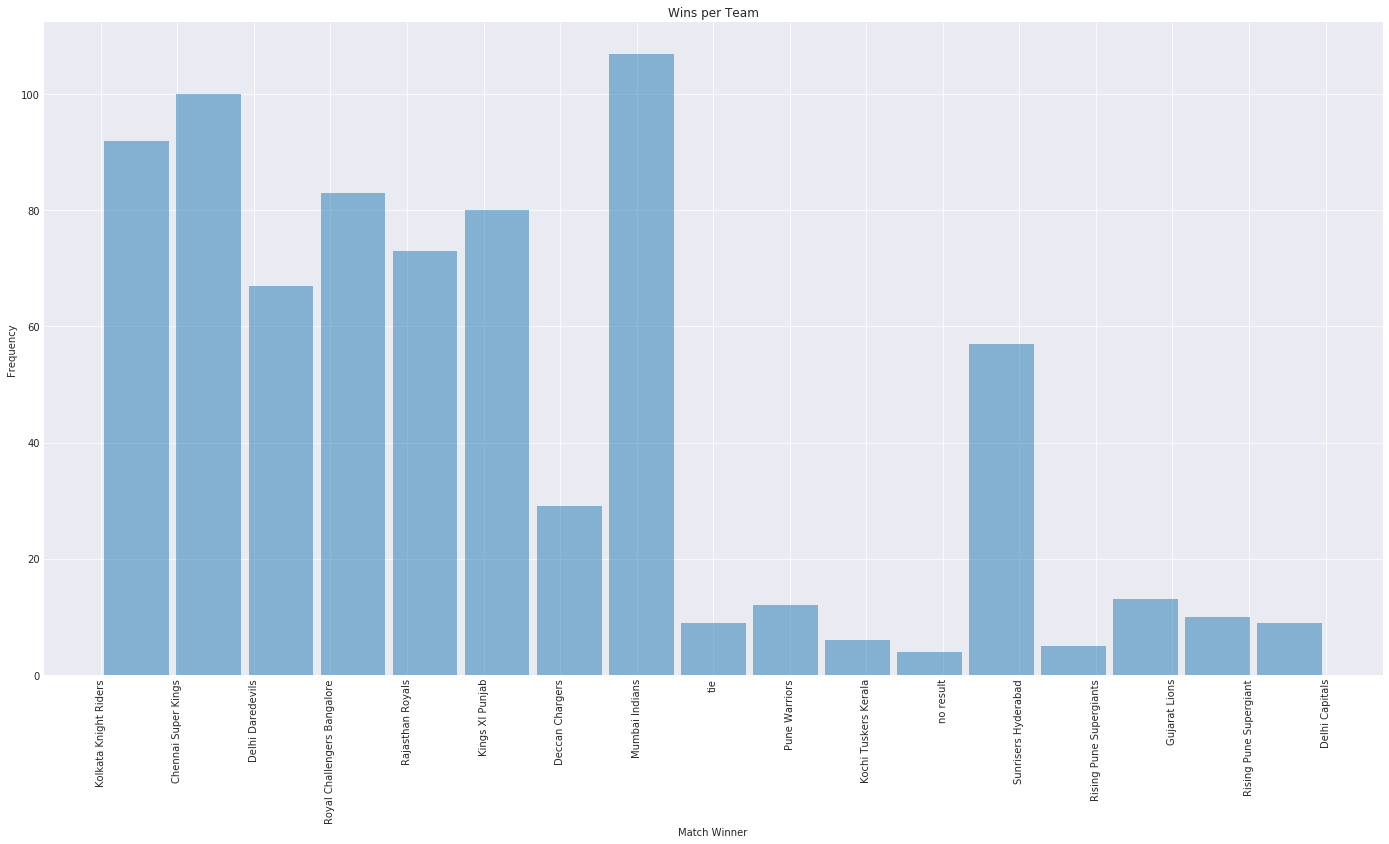

In [46]:
bins = len(dfMatchInfo.Winner.unique())
plt.title("Wins per Team")
plt.hist(dfMatchInfo.Winner, bins=bins, alpha=0.5, rwidth=0.9)
plt.xlabel("Match Winner",)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()

## Histogram For Man-of-the-Match <a class="anchor" id="Histogram-For-Man-of-the-Match"></a>

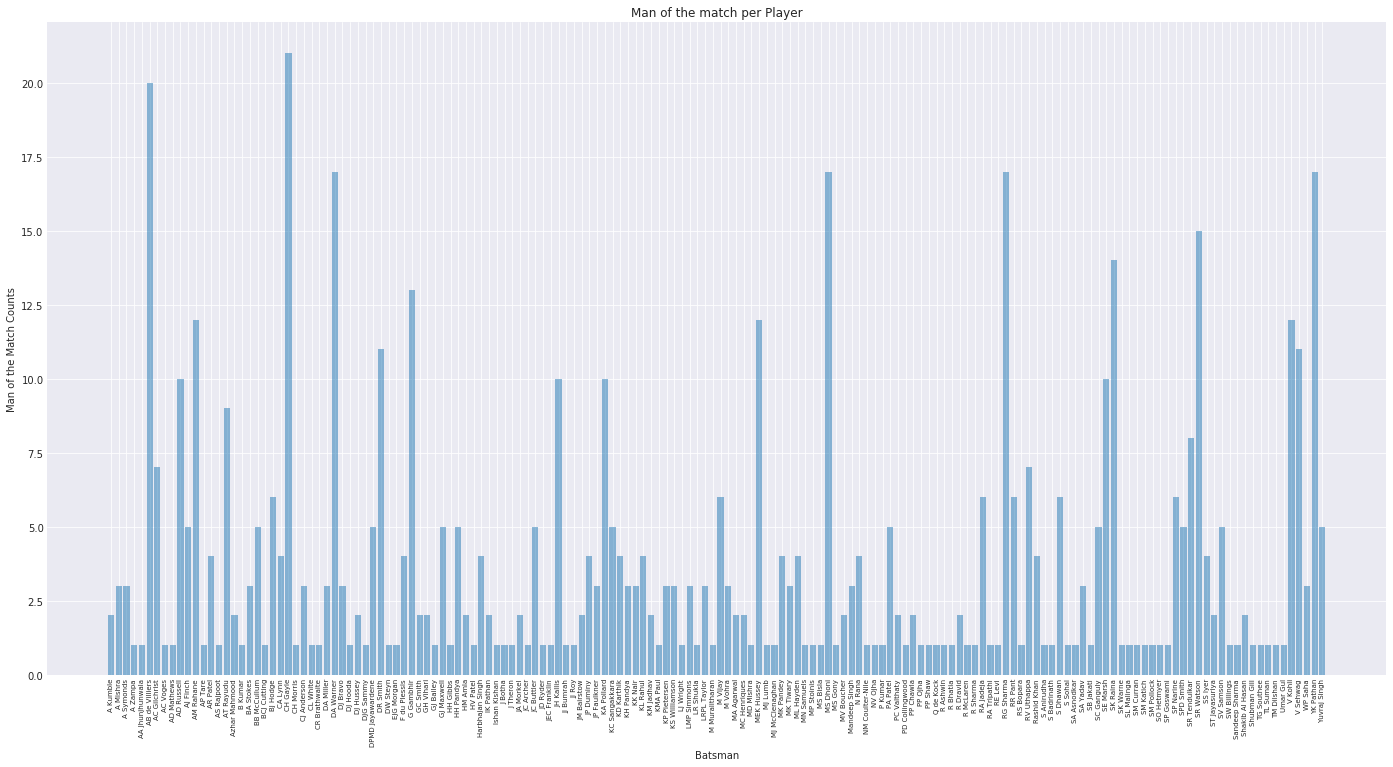

In [47]:
moms = batsmanAllSeason[batsmanAllSeason["ManOfTheMatch"] > 0]
bins = len(moms)
plt.title("Man of the match per Player")
plt.bar(x=moms.index, height=moms["ManOfTheMatch"], alpha=0.5)
plt.xlabel("Batsman",)
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Man of the Match Counts")
plt.show()

## Histogram No of centuries by players <a class="anchor" id="Histogram-No-of-centuries-by-players"></a>

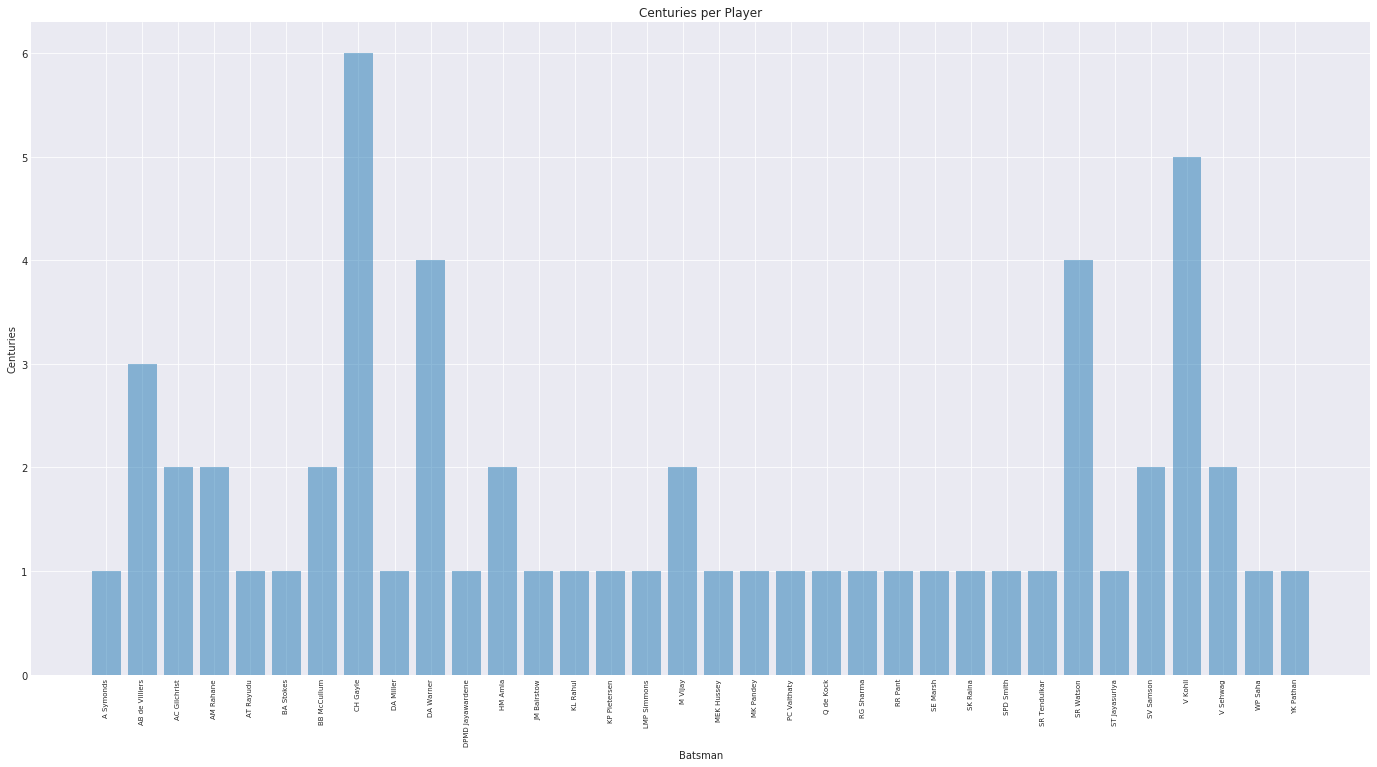

In [48]:
centuries = batsmanAllSeason[batsmanAllSeason["Century"] > 0]
bins = len(centuries)
plt.title("Centuries per Player")
plt.bar(x=centuries.index, height=centuries["Century"], alpha=0.5)
plt.xlabel("Batsman",)
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Centuries")
plt.show()

## Histogram No of half-centuries by players <a class="anchor" id="Histogram-No-of-half-centuries-by-players"></a>

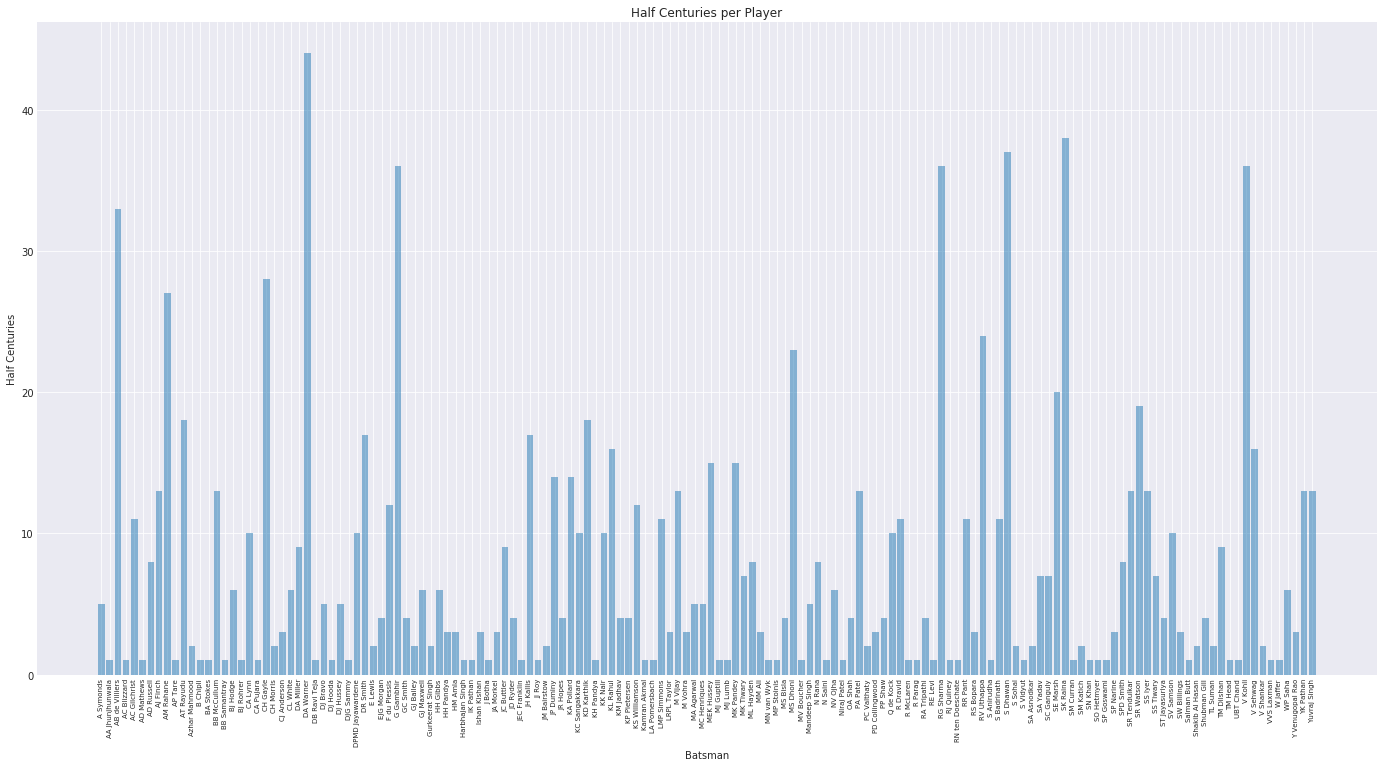

In [49]:
halfCenturies = batsmanAllSeason[batsmanAllSeason["HalfCentury"] > 0]
bins = len(halfCenturies)
plt.title("Half Centuries per Player")
plt.bar(
    x=halfCenturies.index, height=halfCenturies["HalfCentury"], alpha=0.5,
)
plt.xlabel("Batsman",)
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Half Centuries")
plt.show()

## Histogram for Strike Rates by Batsman <a class="anchor" id="Histogram-for-Strike-Rates-by-Batsman"></a>
Strike Rates with > 50 and total runs > 300

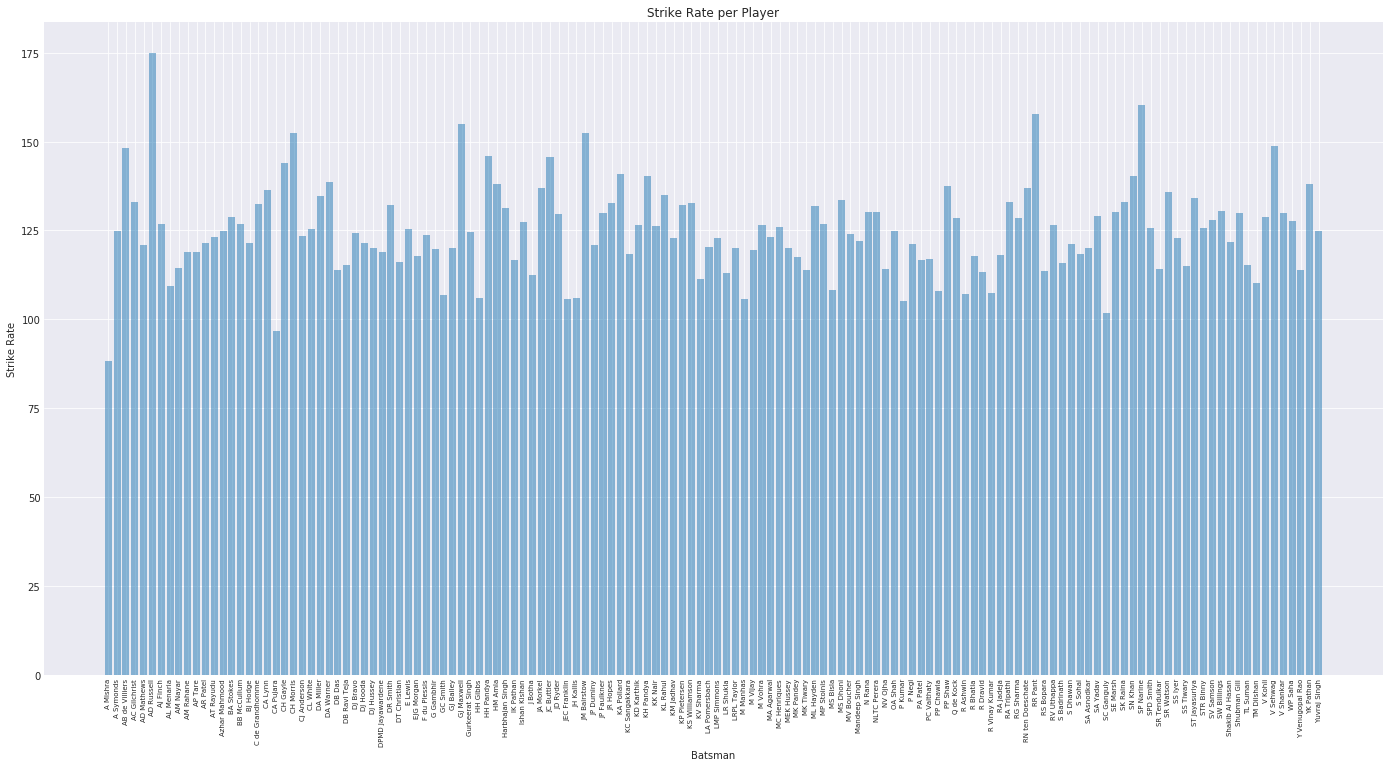

In [50]:
strkRate = batsmanAllSeason[
    (batsmanAllSeason["StrikeRate"] > 80) & (batsmanAllSeason["TotalRuns"] > 300)
]
bins = len(strkRate)
plt.title("Strike Rate per Player")
plt.bar(
    x=strkRate.index, height=strkRate["StrikeRate"], alpha=0.5,
)

plt.xlabel("Batsman",)
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Strike Rate")
plt.show()